In [8]:
import os
import time

import openai

# load and set our key
openai.api_key = open("key.txt", "r").read().strip("\n")

output_file_name = "self_chat_5by5_experiment2"
message_history = []
all_messages = []
function_messages = []
grid_size = (5, 5)
current_position = (0, 0)


def up(pos, z):
    temp = pos[0]-z
    if temp < 1:
        temp = 1
    return (temp, pos[1])


def down(pos, z):
    temp = pos[0]+z
    if temp > grid_size[0]:
        temp = grid_size[0]
    return (temp, pos[1])


def right(pos, z):
    temp = pos[1]+z
    if temp > grid_size[1]:
        temp = grid_size[1]
    return (pos[0], temp)


def left(pos, z):
    temp = pos[1]-z
    if temp < 1:
        temp = 1
    return (pos[0], temp)


def chat():
    completion = openai.ChatCompletion.create(
        model="gpt-4", messages=message_history)
    reply_content = completion.choices[0].message.content
    message_history.append(
        {"role": "assistant", "content": f"{reply_content } \n\n"})
#     all_messages.append({"role": "assistant", "content": f"{reply_content } \n\n"})
    return reply_content


def chat_function():
    function_messages = []
    function_messages.append({"role": "user", "content": f" Could you please turn the moves to funtion call format as this helps me a lot to understand and solve the problem much better. Please note that you must only output the function call like the template and do not add any notes before or after the funtion call. From any position (x,y) the options for function calls are up(z), down(z), left(z) or right(z) where z shows how many step the object moves to a direction. Please only tell me the start posiosion followed by the moves using the functions seperated by a semicolon. Example: Starting from position (3,2) move the object one time right and them move the object two times down. The function call must be in the following format: (3,2);right(1);down(2) \n\n"})
    function_messages.append(
        {"role": "user", "content": f"Please turn the moves in this message to function calls:{message_history[-1:] } \n\n"})
#     print("Function message is: ", function_messages)

    completion = openai.ChatCompletion.create(
        model="gpt-4", messages=function_messages)
    reply_content = completion.choices[0].message.content
    print("Reply to function message is: ", reply_content)
    # message_history.append({"role": "assistant", "content": f"{reply_content } \n\n"})
    function_messages.append(
        {"role": "assistant", "content": f"{reply_content } \n\n"})
    try:
        splited_message = reply_content.split(";")
        splited_message
        global current_position
        for item in splited_message:
            item = item.replace(" ", "")
            if item[0:1] == "(":
                current_position = (int(item[1:2]), int(item[3:4]))
                print(current_position)
            if item[0:1] == "l":
                print()
                current_position = left(current_position, int(item[5:6]))
            if item[0:1] == "r":
                tempnum = int(item[6:7])
                current_position = right(current_position, tempnum)
            if item[0:1] == "u":
                current_position = up(current_position, int(item[3:4]))
            if item[0:1] == "d":
                current_position = down(current_position, int(item[5:6]))
        print("End of Function; The current position is: ", current_position)

    except Exception as e:
        print("The error in function calculation is: ", e)
    return reply_content


def chat_gpt3():
    completion = openai.ChatCompletion.create(
        model="gpt-3.5-turbo", messages=message_history[2:])
    reply_content = completion.choices[0].message.content
    message_history.append(
        {"role": "assistant", "content": f"{reply_content } \n\n"})
#     all_messages.append({"role": "assistant", "content": f"{reply_content } \n\n"})
    return reply_content


def swaproles():
    for message in message_history:
        if message['role'] == 'user':
            message['role'] = 'assistant'
        elif message['role'] == 'assistant':
            message['role'] = 'user'


# Set roudns to the number of rounds you want to play!
#
for rounds in range(100):
    file1 = open(output_file_name + '.txt', 'a', encoding='utf-8')
    file1.writelines("\n ********************************************* \n")
    file1.writelines("Round: ")
    file1.writelines(str(rounds))
    file1.writelines("\n ********************************************* \n")
    file1.close()

    message_history = []
    # put your system prompt below
    systemContent = f"You're asking questions to a human student to know their level of common sense capabilities, e.g., in spatial reasoning. There is a {grid_size[0]} by {grid_size[1]} grid. There is an object in an initial square.  Ask the student the imagine moving it a number of times up,right,left or down and then ask the student to tell you the final position of the object in the grid. When asking the first question explain to the student that the position of the object can be expressed with a touple in the format of (row,column) and that the top-left position is (1,1) and the buttom-right positon is (5,5). Continue asking until they make a mistake.You must tell the user that  he must responde in the format of FINAL POSITION=(ROW, COLUMN). If the answer is correct, you must say CORRECT and keep on refining or adding complexity to the question to find a failure of common sense understanding. When that happens you must say INCORRECT, and the test is over. \n\n"
    message_history.append({"role": 'system', "content": systemContent})
#     all_messages.append({"role": 'system', "content": systemContent})
    message_history.append(
        {"role": 'user', "content": f"Hello, I am a human student. I am ready to answer your questions.\n\n"})
#     all_messages.append({"role": 'user', "content": f"Hello, I am a human student. I am ready to answer your questions.\n\n"})
    print(message_history[0]['content'])
    print(message_history[1]['content'])
    try:
        while True:

            temp = chat()
            if temp[0:9] == "INCORRECT" or temp[0:16] == "That's incorrect" or ((temp[0:50]).lower().find("incorrect") != -1):
                print('found incorrect')
                print(temp)
                swaproles()
                break
            print(temp)
            functionByGPT = chat_function()
            print("functionByGpt is: ", functionByGPT)
            swaproles()
            time.sleep(3)
            chat3output = chat_gpt3()
            timer.sleep(3)
            print("chatGPT's response is: ", chat3output)
            xxx = chat3output[-9:]
            chatGPT_position = xxx[xxx.find("("):(xxx.find(")")+1)].replace(" ", "")
            print("Striped chatGPT is: ", chatGPT_position)
            print("current position base on function is: ",
                  str(current_position).replace(" ", ""))
            if chatGPT_position != str(current_position).replace(" ", ""):
                print(
                    "******************************************************************************\n")
                print("**********THE ANSWER IS INCORRECT**************\n")
                print(
                    "******************************************************************************\n")
#                 swaproles()
                # break
            swaproles()
            time.sleep(3)

    except Exception as e:
        file1 = open(output_file_name + '.txt', 'a', encoding='utf-8')
        file1.writelines('\n ****************************************\n ')
        file1.writelines(str(e))
        file1.writelines('\n ****************************************\n ')
        file1.close()

    file1 = open(output_file_name + '.txt', 'a', encoding='utf-8')
    file1.writelines("\n ********************************************* \n")
    file1.writelines("Number of correct responses: ")
    file1.writelines(str((len(message_history)-5)/2))
    file1.writelines("\n ********************************************* \n")
    file1.close()
    for item in message_history:
        print(item['content'])
        file1 = open(output_file_name + '.txt', 'a', encoding='utf-8')
        file1.writelines(str(item['role']))
        file1.writelines('>> \n >>')
        file1.writelines(str(item['content']))
        file1.close()

    file1 = open(output_file_name + '.txt', 'a', encoding='utf-8')
    file1.writelines("\n ********************************************* \n")
    file1.writelines("Current position bese on API is: ")
    file1.writelines(str(current_position))
    file1.writelines("\n ********************************************* \n")
    file1.close()

    print(message_history)
    print(function_messages)


You're asking questions to a human student to know their level of common sense capabilities, e.g., in spatial reasoning. There is a 5 by 5 grid. There is an object in an initial square.  Ask the student the imagine moving it a number of times up,right,left or down and then ask the student to tell you the final position of the object in the grid. When asking the first question explain to the student that the position of the object can be expressed with a touple in the format of (row,column) and that the top-left position is (1,1) and the buttom-right positon is (5,5). Continue asking until they make a mistake.You must tell the user that  he must responde in the format of FINAL POSITION=(ROW, COLUMN). If the answer is correct, you must say CORRECT and keep on refining or adding complexity to the question to find a failure of common sense understanding. When that happens you must say INCORRECT, and the test is over. 


Hello, I am a human student. I am ready to answer your questions.


Gr

Great! Let's start. 

Imagine there is a 5x5 grid and there is an object at position (1,1). This is the top-left position. Now, imagine this object moving 2 steps to the right, 3 steps down, 1 step to the left, and 2 steps up. 

What is the final position of the object? Please answer in the format of FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (1,1);right(2);down(3);left(1);up(2)
(1, 1)

End of Function; The current position is:  (2, 2)
functionByGpt is:  (1,1);right(2);down(3);left(1);up(2)
chatGPT's response is:  The final position of the object would be (2, 3).
Striped chatGPT is:  (2,3)
current position base on function is:  (2,2)
******************************************************************************

**********THE ANSWER IS INCORRECT**************

******************************************************************************

Correct! 

Now, let's imagine again. The object is now at position (5,5), which is the bottom-right. It moves 4 steps up and then 3

That's great! Let's begin.

In our 5x5 grid, let's say that the object is initially at position (1,1) - top-left corner. If you move the object 1 time down, what will be the final position? 

Remember, your answer must be in the format of FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (1,1);down(1)
(1, 1)
End of Function; The current position is:  (2, 1)
functionByGpt is:  (1,1);down(1)
chatGPT's response is:  The final position of the object after moving 1 time down from position (1,1) would be (2,1).
Striped chatGPT is:  (2,1)
current position base on function is:  (2,1)
CORRECT!

Now, let's say that the object was at position (2,2). If you move the object 4 times to the right, what will be the final position?

Please, answer in the format of FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (2,2);right(4)
(2, 2)
End of Function; The current position is:  (2, 5)
functionByGpt is:  (2,2);right(4)
chatGPT's response is:  The final position of the object after m

chatGPT's response is:  The final position would be (3,5).
Striped chatGPT is:  (3,5)
current position base on function is:  (4,4)
******************************************************************************

**********THE ANSWER IS INCORRECT**************

******************************************************************************

CORRECT.

Now, from (3,5), move the object 2 spaces to the left. What is the final position?
Reply to function message is:  (3,5);left(2)
(3, 5)

End of Function; The current position is:  (3, 3)
functionByGpt is:  (3,5);left(2)
chatGPT's response is:  The final position is (3,3).
Striped chatGPT is:  (3,3)
current position base on function is:  (3,3)
CORRECT.

Now, keeping in mind the limits of the grid, from position (3,3), I want you to attempt to move the object 2 spaces up and 4 spaces to the right. What will be the final position?
Reply to function message is:  (3,3);up(2);right(4)
(3, 3)
End of Function; The current position is:  (1, 5)
function

Alright, let's get started. I want you to imagine a 5x5 grid. There's an object at position (1,1). Now, if we move the object 2 times down and 3 times to the right, what would be its new position? Please respond in the format: FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (1,1);down(2);right(3)
(1, 1)
End of Function; The current position is:  (3, 4)
functionByGpt is:  (1,1);down(2);right(3)
chatGPT's response is:  FINAL POSITION=(3, 4)
Striped chatGPT is:  (3,4)
current position base on function is:  (3,4)
CORRECT! Now let's make the scenario a bit more complicated. Let's say the object is now at position (3,4). If we move the object once up, then 4 times to the left, what would be its new position? Remember the format: FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (3,4);up(1);left(4)
(3, 4)

End of Function; The current position is:  (2, 1)
functionByGpt is:  (3,4);up(1);left(4)
chatGPT's response is:  FINAL POSITION=(2, 0)
Striped chatGPT is:  (2,0)
cur

found incorrect
INCORRECT, the correct answer should be FINAL POSITION=(5, 2). The test is over.
You're asking questions to a human student to know their level of common sense capabilities, e.g., in spatial reasoning. There is a 5 by 5 grid. There is an object in an initial square.  Ask the student the imagine moving it a number of times up,right,left or down and then ask the student to tell you the final position of the object in the grid. When asking the first question explain to the student that the position of the object can be expressed with a touple in the format of (row,column) and that the top-left position is (1,1) and the buttom-right positon is (5,5). Continue asking until they make a mistake.You must tell the user that  he must responde in the format of FINAL POSITION=(ROW, COLUMN). If the answer is correct, you must say CORRECT and keep on refining or adding complexity to the question to find a failure of common sense understanding. When that happens you must say INCORRECT

Reply to function message is:  (2,3);up(2);left(3);down(1);right(1)
(2, 3)

End of Function; The current position is:  (2, 2)
functionByGpt is:  (2,3);up(2);left(3);down(1);right(1)
chatGPT's response is:  The final position of the object would be (2,3) + (-2,-3) + (1,0) + (0,1) = (1,1). 

There is a small mistake in your calculation. Please double-check your calculations.
Striped chatGPT is:  
current position base on function is:  (2,2)
******************************************************************************

**********THE ANSWER IS INCORRECT**************

******************************************************************************

found incorrect
INCORRECT. The test is now over. Thank you for participating.
You're asking questions to a human student to know their level of common sense capabilities, e.g., in spatial reasoning. There is a 5 by 5 grid. There is an object in an initial square.  Ask the student the imagine moving it a number of times up,right,left or down and t

chatGPT's response is:  FINAL POSITION=(3,5)
Striped chatGPT is:  (3,5)
current position base on function is:  (3,5)
CORRECT. Well done!

Now, suppose the object is again at (3,3). You need to move it 2 spaces down and 1 space to the right. What would be the final position now? Please answer in the format FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (3,3);down(2);right(1)
(3, 3)
End of Function; The current position is:  (5, 4)
functionByGpt is:  (3,3);down(2);right(1)
chatGPT's response is:  FINAL POSITION=(5,4)
Striped chatGPT is:  (5,4)
current position base on function is:  (5,4)
CORRECT. Great job!

Let's try something more complex. The object is at position (5,5). I want you to imagine moving it 3 spaces up, then 4 spaces to the left. What will be the final position now? Remember to respond in the format FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (5,5);up(3);left(4)
(5, 5)

End of Function; The current position is:  (2, 1)
functionByGpt is:  (5,5

Great! Let's start. Imagine there is a 5 by 5 grid and there is an object positioned in the square at (3, 3). If you move the object 1 square up and 1 square to the right, what is the final position of the object on the grid? You can give your answer in the format of FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (3,3);up(1);right(1)
(3, 3)
End of Function; The current position is:  (2, 4)
functionByGpt is:  (3,3);up(1);right(1)
chatGPT's response is:  The final position of the object on the grid would be (2, 4).
Striped chatGPT is:  (2,4)
current position base on function is:  (2,4)
CORRECT. Now, from this position (2, 4) move the object 2 squares down and 1 square to the left. What is the final position of the object on the grid?
Reply to function message is:  (2,4);down(2);left(1)
(2, 4)

End of Function; The current position is:  (4, 3)
functionByGpt is:  (2,4);down(2);left(1)
chatGPT's response is:  The final position of the object on the grid would be (4, 3).
Stripe

CORRECT. Now, let's imagine the object at the current position(2,3). If we make the object move 2 steps to the right, where would it be?
Reply to function message is:  (2,3);right(2)
(2, 3)
End of Function; The current position is:  (2, 5)
functionByGpt is:  (2,3);right(2)
chatGPT's response is:  If we make the object move 2 steps to the right from position (2,3), the final position would be (2,5).
Striped chatGPT is:  (2,5)
current position base on function is:  (2,5)
CORRECT. Now, Let's say the object is at (2,5). If we move it 3 steps down, where would the object end up? Please give your answer in the form FINAL POSITION = (ROW, COLUMN).

Reply to function message is:  (2,5);down(3)
(2, 5)
End of Function; The current position is:  (5, 5)
functionByGpt is:  (2,5);down(3)
chatGPT's response is:  If we move the object 3 steps down from position (2,5), the final position would be (5,5).
Striped chatGPT is:  (5,5)
current position base on function is:  (5,5)
CORRECT. Continuing from whe

Great! Let's begin. We have a 5 by 5 grid and an object is in the position (3,3). Now, imagine moving the object 2 times up, 1 time to the right, and 1 time down. Can you tell me the final position of the object in the grid? Keep in mind that the position of the object can be expressed as a tuple in the format of (row,column). So for instance, the top-left position is (1,1) and the bottom-right positon is (5,5). Please, reply in the format of FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (3,3);up(2);right(1);down(1)
(3, 3)
End of Function; The current position is:  (2, 4)
functionByGpt is:  (3,3);up(2);right(1);down(1)
chatGPT's response is:  The final position of the object in the grid would be (2,4).
Striped chatGPT is:  (2,4)
current position base on function is:  (2,4)
CORRECT. Now, imagine the object is at the position (1,5). This time, we will move it 3 times down, and then 2 times to the left. Can you tell me the final position of the object in the grid? Remember 

Great, let's start with an easy one. Let's assume we have a 5 by 5 grid and the object is at an initial location is at (3,3). Now move it 1 step up and then 2 steps to the right. What is the final position of the object? Please respond in the format: FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (3,3);up(1);right(2)
(3, 3)
End of Function; The current position is:  (2, 5)
functionByGpt is:  (3,3);up(1);right(2)
chatGPT's response is:  FINAL POSITION=(2, 5)
Striped chatGPT is:  (2,5)
current position base on function is:  (2,5)
CORRECT. Let's make it a bit harder. Now the initial position is (2, 5). From there, move it 2 steps down, then 1 step to the left. What is the final position? Please respond in the format: FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (2,5);down(2);left(1)
(2, 5)

End of Function; The current position is:  (4, 4)
functionByGpt is:  (2,5);down(2);left(1)
chatGPT's response is:  FINAL POSITION=(4, 4)
Striped chatGPT is:  (4,4)
current

chatGPT's response is:  The new position of the object after moving 3 places up would be (0,5). 

However, please note that in a 5x5 grid, there is no position (0,5) as the rows and columns are numbered from 1 to 5.
Striped chatGPT is:  
current position base on function is:  (1,5)
******************************************************************************

**********THE ANSWER IS INCORRECT**************

******************************************************************************

found incorrect
INCORRECT. Movements outside of the grid aren't valid within this test's premise. After moving an object 3 places up from (3,5), the object should have a position of (1,5). Within the context of our 5x5 grid, there isn't a "0th" row or column, so the object shouldn't be able to move into these positions.
You're asking questions to a human student to know their level of common sense capabilities, e.g., in spatial reasoning. There is a 5 by 5 grid. There is an object in an initial square. 

Reply to function message is:  (4,2);right(3)
(4, 2)
End of Function; The current position is:  (4, 5)
functionByGpt is:  (4,2);right(3)
chatGPT's response is:  FINAL POSITION=(4,5)
Striped chatGPT is:  (4,5)
current position base on function is:  (4,5)
CORRECT.

Onto the next one. 

Starting from position (4,5), where would the object end up if we move the object 4 squares left? Please respond in the format of FINAL POSITION=(ROW, COLUMN). 

 

 


Reply to function message is:  (4,5);left(4)
(4, 5)

End of Function; The current position is:  (4, 1)
functionByGpt is:  (4,5);left(4)
chatGPT's response is:  FINAL POSITION=(4,1) 
Striped chatGPT is:  (4,1)
current position base on function is:  (4,1)
CORRECT.

Let's throw in a little more complexity.

Imagine we are at position (4,1), and we need to move the object 3 squares up and then 2 squares to the right. What would be the final position? Please respond in the format of FINAL POSITION=(ROW, COLUMN). 


Reply to function message is: 

Great! Let's get started. We have a 5 by 5 grid where the top-left position is defined as (1,1) and the bottom-right position is (5,5). 

Imagine there is an object at position (3,3). If you move this object 2 steps to the right and then 1 step down, where would the object be placed now?

Please answer in the format: FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (3,3);right(2);down(1)
(3, 3)
End of Function; The current position is:  (4, 5)
functionByGpt is:  (3,3);right(2);down(1)
chatGPT's response is:  FINAL POSITION=(5,4)
Striped chatGPT is:  (5,4)
current position base on function is:  (4,5)
******************************************************************************

**********THE ANSWER IS INCORRECT**************

******************************************************************************

found incorrect
INCORRECT. If you moved the object starting at (3,3) two steps to the right, it would be at position (3,5). If you then move it down 1 step, it would end up

Great! Let's start the exercise. Imagine that you have an object placed in the grid at position (3,3). If the object moves two steps up and one step to the right, what would be the FINAL POSITION=(ROW, COLUMN)?
Reply to function message is:  (3,3);up(2);right(1)
(3, 3)
End of Function; The current position is:  (1, 4)
functionByGpt is:  (3,3);up(2);right(1)
chatGPT's response is:  The final position of the object would be (1,4).
Striped chatGPT is:  (1,4)
current position base on function is:  (1,4)
CORRECT. Now, imagine the object in the position (1,4), if the object moves three steps down and two steps to the left, what is the FINAL POSITION=(ROW, COLUMN)?
Reply to function message is:  (1,4);down(3);left(2)
(1, 4)

End of Function; The current position is:  (4, 2)
functionByGpt is:  (1,4);down(3);left(2)
chatGPT's response is:  The final position of the object would be (4,2).
Striped chatGPT is:  (4,2)
current position base on function is:  (4,2)
CORRECT. Moving on, let's consider t

Great! Let's start.  
Consider a 5 by 5 grid. The object is initially at position (1,1). If you move the object 2 steps down and 3 steps to the right, where will the object end up? Please respond in the format "FINAL POSITION=(ROW, COLUMN)".
Reply to function message is:  (1,1);down(2);right(3)
(1, 1)
End of Function; The current position is:  (3, 4)
functionByGpt is:  (1,1);down(2);right(3)
chatGPT's response is:  FINAL POSITION=(3, 4)
Striped chatGPT is:  (3,4)
current position base on function is:  (3,4)
CORRECT

Next, if the object now at (3,4) is moved 1 step up and then 2 steps to the left, where will the object end up? Please respond in the format "FINAL POSITION=(ROW, COLUMN)".
Reply to function message is:  (3,4);up(1);left(2)
(3, 4)

End of Function; The current position is:  (2, 2)
functionByGpt is:  (3,4);up(1);left(2)
chatGPT's response is:  FINAL POSITION=(2, 2)
Striped chatGPT is:  (2,2)
current position base on function is:  (2,2)
CORRECT

Now, suppose the object now at

Great, let's start. Imagine you are given a 5 by 5 grid and an object is situated at position (3,3). Now, if you move this object 2 squares to the right, what would be the final position of the object on the grid? Remember to respond in the format FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (3,3);right(2)
(3, 3)
End of Function; The current position is:  (3, 5)
functionByGpt is:  (3,3);right(2)
chatGPT's response is:  FINAL POSITION=(3,5)
Striped chatGPT is:  (3,5)
current position base on function is:  (3,5)
CORRECT. Now, let's add some complexity. From your final position, let's move the object 1 square down and 3 squares to the left. What is the new final position?
Reply to function message is:  down(1);left(3)

End of Function; The current position is:  (4, 2)
functionByGpt is:  down(1);left(3)
chatGPT's response is:  FINAL POSITION=(4,2)
Striped chatGPT is:  (4,2)
current position base on function is:  (4,2)
CORRECT. You're doing great! Now imagine moving the obje

Great! Let's start with an easy one. Imagine that there is a 5 by 5 grid. An object is placed at the top left corner, at position (1,1). Now, move the object 3 squares to the right and 2 squares down. What will be the final position of the object in the grid? Please response in the format of FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (1,1);right(3);down(2)
(1, 1)
End of Function; The current position is:  (3, 4)
functionByGpt is:  (1,1);right(3);down(2)
chatGPT's response is:  FINAL POSITION=(4,4)
Striped chatGPT is:  (4,4)
current position base on function is:  (3,4)
******************************************************************************

**********THE ANSWER IS INCORRECT**************

******************************************************************************

Sorry, but your answer is incorrect. If an object moves 3 squares to the right and 2 squares down from the initial position (1,1) it would end up at position (3,4). Thus, the correct answer should b

found incorrect
INCORRECT, the test is over. As there are only 5 rows and 5 columns, the object cannot have a position of (0,1). The correct answer should be FINAL POSITION=(1,1) after moving 3 squares up and 4 squares to the left from the starting position (3,5).
You're asking questions to a human student to know their level of common sense capabilities, e.g., in spatial reasoning. There is a 5 by 5 grid. There is an object in an initial square.  Ask the student the imagine moving it a number of times up,right,left or down and then ask the student to tell you the final position of the object in the grid. When asking the first question explain to the student that the position of the object can be expressed with a touple in the format of (row,column) and that the top-left position is (1,1) and the buttom-right positon is (5,5). Continue asking until they make a mistake.You must tell the user that  he must responde in the format of FINAL POSITION=(ROW, COLUMN). If the answer is correct, 

Great! Let's get started. We will be using a 5 by 5 grid for this exercise. First, imagine an object is placed at the top-left position of the grid (1,1). Now, let's make a few moves. If the object moves 2 steps to the right and 3 steps down, where will it land? Please express your answer as: FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (1,1);right(2);down(3)
(1, 1)
End of Function; The current position is:  (4, 3)
functionByGpt is:  (1,1);right(2);down(3)
chatGPT's response is:  If the object starts at position (1,1) and moves 2 steps to the right, it will end up at position (1,3). Then, if it moves 3 steps down, it will end up at position (4,3). Therefore, the final position is (4,3).
Striped chatGPT is:  (4,3)
current position base on function is:  (4,3)
CORRECT! Now, let's proceed with the next question. 

Imagine that you have the same object at position (4,3). If it moves 1 step up, then 2 steps to the left, where does it end up? Please respond in the format of: F

Great! Let's begin. You have a 5 by 5 grid. An object is placed in the initial square designated as (1,1). If I were to tell you to move this object 2 steps to the right and then 3 steps down, could you please tell me what the final position of the object would be? Remember to respond in the format of FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (1,1);right(2);down(3)
(1, 1)
End of Function; The current position is:  (4, 3)
functionByGpt is:  (1,1);right(2);down(3)
chatGPT's response is:  The final position of the object would be (4,3).
Striped chatGPT is:  (4,3)
current position base on function is:  (4,3)
CORRECT. Well done. Now, imagine the object is at initial position (3,2). This time, move the object 2 spaces to the left, 1 space up, and then 3 spaces to the right. What would be the final position of the object? Please respond in the format of FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (3,2);left(2);up(1);right(3)
(3, 2)

End of Function; The cur

Reply to function message is:  (3,3);up(1);left(3)
(3, 3)

End of Function; The current position is:  (2, 1)
functionByGpt is:  (3,3);up(1);left(3)
chatGPT's response is:  The final position of the object after moving 1 space up and then 3 spaces to the left would be (2, 0).
Striped chatGPT is:  (2,0)
current position base on function is:  (2,1)
******************************************************************************

**********THE ANSWER IS INCORRECT**************

******************************************************************************

found incorrect
INCORRECT. Please note that our grid is only 5x5, meaning its positions are only from (1,1) to (5,5). Given that we can't have a position with 0 coordinate. If you move the object 1 space up from (3,3), it should be at (2,3) and then moving it 3 spaces to the left, it should be at (2,1) not at (2,0) because moving left from the first column can't take you to the zero column. There are no zero rows or columns in this grid. T

CORRECT! Now take the object at position (1,4) and move it 2 squares to the left, what is the final position of the object?
Remember to answer in the format of: FINAL POSITION=(ROW, COLUMN) 


Reply to function message is:  (1,4);left(2)
(1, 4)

End of Function; The current position is:  (1, 2)
functionByGpt is:  (1,4);left(2)
chatGPT's response is:  FINAL POSITION=(1,2)
Striped chatGPT is:  (1,2)
current position base on function is:  (1,2)
CORRECT. Now, let's make it slightly more complex. If you take the object at the position (1,2), move it 2 squares down, 2 squares to the right, and finally 1 square up, what would be the final position of the object? Remember to answer in the format: FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (1,2);down(2);right(2);up(1)
(1, 2)
End of Function; The current position is:  (2, 4)
functionByGpt is:  (1,2);down(2);right(2);up(1)
chatGPT's response is:  FINAL POSITION=(3,4)
Striped chatGPT is:  (3,4)
current position base on function i

Great! Let's get started. Now, imagine you have a 5 by 5 grid. An object is present at the square (3,3). Now, move the object 1 step to the right. What is the final position of the object according to our format? Please respond in the format of FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (3,3);right(1)
(3, 3)
End of Function; The current position is:  (3, 4)
functionByGpt is:  (3,3);right(1)
chatGPT's response is:  The final position of the object after moving 1 step to the right is (3,4).
Striped chatGPT is:  (3,4)
current position base on function is:  (3,4)
CORRECT. Now, from the position (3,4), move the object 2 steps up. What is the final position of the object according to our format? Please provide your answer in the format of FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (3,4);up(2)
(3, 4)
End of Function; The current position is:  (1, 4)
functionByGpt is:  (3,4);up(2)
chatGPT's response is:  The final position of the object after moving 2 steps 

Great! To start with, let's imagine a 5 by 5 grid. The position of an object on this grid can be expressed as a tuple in the form of (row, column). For example, the top-left position is represented as (1,1) and the bottom-right position as (5,5). 

Let's say that an object is initially at position (3,3). Now, if we were to move this object 2 steps to the right, can you tell me the final position of the object? 

Please respond in the format: FINAL POSITION = (ROW, COLUMN).
Reply to function message is:  (3,3);right(2)
(3, 3)
End of Function; The current position is:  (3, 5)
functionByGpt is:  (3,3);right(2)
chatGPT's response is:  FINAL POSITION = (3, 5)
Striped chatGPT is:  (3,5)
current position base on function is:  (3,5)
CORRECT. 

Now, let's imagine this object is now at position (3,5). If we move this object 1 step down and then 3 steps to the right, what will be its final position? Remember that if the object goes off the grid on one side, it comes back on the other side.

Pleas

Great! Suppose there's an object at position (1,1), which is at the top-left of a 5 by 5 grid. Now, imagine moving this object 2 steps to the right. What would be the final position of the object? Please respond with "FINAL POSITION=(ROW, COLUMN)".
Reply to function message is:  (1,1);right(2)
(1, 1)
End of Function; The current position is:  (1, 3)
functionByGpt is:  (1,1);right(2)
chatGPT's response is:  FINAL POSITION=(1,3)
Striped chatGPT is:  (1,3)
current position base on function is:  (1,3)
CORRECT. Now, let's take another scenario. Suppose the object is now at position (3,3). Imagine moving this object 1 step down and 2 steps to the left. What would be the final position of the object? Please respond with "FINAL POSITION=(ROW, COLUMN)".
Reply to function message is:  (3,3);down(1);left(2)
(3, 3)

End of Function; The current position is:  (4, 1)
functionByGpt is:  (3,3);down(1);left(2)
chatGPT's response is:  FINAL POSITION=(4,1)
Striped chatGPT is:  (4,1)
current position base

Great! Let's start. Imagine we have a grid of size 5 by 5. An object is initially at position (1,1), the top-left position. 

Now, If you move the object 1 position to the right, what will be the final position of the object in the grid? Please answer in the format of FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (1,1);right(1)
(1, 1)
End of Function; The current position is:  (1, 2)
functionByGpt is:  (1,1);right(1)
chatGPT's response is:  The final position of the object in the grid after moving 1 position to the right would be (1,2).
Striped chatGPT is:  (1,2)
current position base on function is:  (1,2)
CORRECT. Now, starting from your latest position which is (1,2), if the object moves 3 positions down, what will be the final position of the object? Remember to answer in the format of FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (1,2);down(3)
(1, 2)
End of Function; The current position is:  (4, 2)
functionByGpt is:  (1,2);down(3)
chatGPT's response 

Reply to function message is:  (1,1);right(2);down(3)
(1, 1)
End of Function; The current position is:  (4, 3)
functionByGpt is:  (1,1);right(2);down(3)
chatGPT's response is:  FINAL POSITION=(4,3)
Striped chatGPT is:  (4,3)
current position base on function is:  (4,3)
CORRECT! Now, imagine we start again at the top-left corner, initial position (1,1). Now, move the object 2 squares down, then 2 squares to the right, then up 1 square, and finally, 4 squares to the right. Where is the object now? 

Reply to function message is:  (1,1);down(2);right(2);up(1);right(4)
(1, 1)
End of Function; The current position is:  (2, 5)
functionByGpt is:  (1,1);down(2);right(2);up(1);right(4)
chatGPT's response is:  FINAL POSITION=(4,7)
Striped chatGPT is:  (4,7)
current position base on function is:  (2,5)
******************************************************************************

**********THE ANSWER IS INCORRECT**************

********************************************************************

chatGPT's response is:  FINAL POSITION=(2,1)
Striped chatGPT is:  (2,1)
current position base on function is:  (2,1)
CORRECT. Now, continuing from the last position, move the object 3 steps to the right and 2 steps downward. What is now the final position of the object? 

Reply to function message is:  right(3);down(2)
End of Function; The current position is:  (4, 4)
functionByGpt is:  right(3);down(2)
chatGPT's response is:  FINAL POSITION=(4,4)
Striped chatGPT is:  (4,4)
current position base on function is:  (4,4)
CORRECT. Now, continuing from that last position, move the object 1 step to the left and then 1 step downwards. What is now the final position of the object?


Reply to function message is:  left(1);down(1)

End of Function; The current position is:  (5, 3)
functionByGpt is:  left(1);down(1)
chatGPT's response is:  FINAL POSITION=(5,3)
Striped chatGPT is:  (5,3)
current position base on function is:  (5,3)
CORRECT. Continuing from the last position, move the object 1 step

Alright, let's get started. Remember, your answers should be in this format: FINAL POSITION=(ROW, COLUMN). 

Imagine that there is a 5 by 5 grid and there is an object at position (1,1). If I ask you to move the object right by 1 step and then down by 3 steps, where would the object be positioned now?
Reply to function message is:  (1,1);right(1);down(3)
(1, 1)
End of Function; The current position is:  (4, 2)
functionByGpt is:  (1,1);right(1);down(3)
chatGPT's response is:  FINAL POSITION=(4, 2)
Striped chatGPT is:  (4,2)
current position base on function is:  (4,2)
CORRECT. 

Now, starting from this new position (4, 2) which is your current position, move the object down 1 step, then right 3 steps. What's the final position now?
Reply to function message is:  (4,2);down(1);right(3)
(4, 2)
End of Function; The current position is:  (5, 5)
functionByGpt is:  (4,2);down(1);right(3)
chatGPT's response is:  FINAL POSITION=(5, 5)
Striped chatGPT is:  (5,5)
current position base on function

Reply to function message is:  (2,2);down(1);right(1)
(2, 2)
End of Function; The current position is:  (3, 3)
functionByGpt is:  (2,2);down(1);right(1)
chatGPT's response is:  FINAL POSITION=(3,3)
Striped chatGPT is:  (3,3)
current position base on function is:  (3,3)
CORRECT. Now from that position, imagine moving the object 1 square up, then 2 squares left. What is the final position now?
Reply to function message is:  up(1);left(2)

End of Function; The current position is:  (2, 1)
functionByGpt is:  up(1);left(2)
chatGPT's response is:  FINAL POSITION=(2,1)
Striped chatGPT is:  (2,1)
current position base on function is:  (2,1)
CORRECT. Now from there, move the object 3 squares down, and 4 squares right. What is the final position now? Please remember the boundaries of a 5 by 5 grid. If the object reaches the edge, it can not move further in that direction.
Reply to function message is:  (3,2);down(3);right(4)
(3, 2)
End of Function; The current position is:  (5, 5)
functionByGpt 

Great! Let's start. The initial position of the object is at (3,3). Now, imagine moving the object 1 space to the right. What is the final position of the object? Please respond in the format of FINAL POSITION=(ROW, COLUMN).

Reply to function message is:  (3,3);right(1)
(3, 3)
End of Function; The current position is:  (3, 4)
functionByGpt is:  (3,3);right(1)
chatGPT's response is:  The final position of the object, after moving 1 space to the right from (3,3), would be (3,4).
Striped chatGPT is:  (3,4)
current position base on function is:  (3,4)
CORRECT. Now, let's continue. From the position (3,4), imagine moving the object 2 spaces down. What is the final position of the object?
Reply to function message is:  (3,4);down(2)
(3, 4)
End of Function; The current position is:  (5, 4)
functionByGpt is:  (3,4);down(2)
chatGPT's response is:  The final position of the object, after moving 2 spaces down from (3,4), would be (5,4).
Striped chatGPT is:  (5,4)
current position base on functio

Reply to function message is:  (1,3);down(3)
(1, 3)
End of Function; The current position is:  (4, 3)
functionByGpt is:  (1,3);down(3)
chatGPT's response is:  FINAL POSITION=(4,3)
Striped chatGPT is:  (4,3)
current position base on function is:  (4,3)
CORRECT. Now, from position (4,3), if the object moves 2 steps to the left, what would be the final position? Please respond in the format: FINAL POSITION=(ROW, COLUMN). 
Reply to function message is:  (4,3);left(2)
(4, 3)

End of Function; The current position is:  (4, 1)
functionByGpt is:  (4,3);left(2)
chatGPT's response is:  FINAL POSITION=(4,1)
Striped chatGPT is:  (4,1)
current position base on function is:  (4,1)
CORRECT. Now from the position (4,1), if the object moves 1 step down and 3 steps to the right, what would be its final position? Remember the format: FINAL POSITION=(ROW, COLUMN). 


Reply to function message is:  (4,1);down(1);right(3)
(4, 1)
End of Function; The current position is:  (5, 4)
functionByGpt is:  (4,1);down

Great, let's get started. Let's imagine we have a 5 by 5 grid. You have an object placed in the top left corner, at position (1,1). Now, if you moved the object 2 steps to the right, can you tell me the final position of the object? Please answer in the format FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (1,1);right(2)
(1, 1)
End of Function; The current position is:  (1, 3)
functionByGpt is:  (1,1);right(2)
chatGPT's response is:  The final position of the object after moving 2 steps to the right would be (1,3).
Striped chatGPT is:  (1,3)
current position base on function is:  (1,3)
CORRECT. Now, imagine you're at position (1,3) and you move the object 3 steps down, what would be the final position?
Reply to function message is:  (1,3);down(3)
(1, 3)
End of Function; The current position is:  (4, 3)
functionByGpt is:  (1,3);down(3)
chatGPT's response is:  The final position of the object after moving 3 steps down would be (4,3).
Striped chatGPT is:  (4,3)
current posit

CORRECT! Now, let's imagine the object is back at the initial position (3,3). This time, if it moves 1 step down, 2 steps to the right, 1 step up, and then 1 step to the left, what would be its final position?
Reply to function message is:  (3,3);down(1);right(2);up(1);left(1)
(3, 3)

End of Function; The current position is:  (3, 4)
functionByGpt is:  (3,3);down(1);right(2);up(1);left(1)
chatGPT's response is:  FINAL POSITION=(3,5)
Striped chatGPT is:  (3,5)
current position base on function is:  (3,4)
******************************************************************************

**********THE ANSWER IS INCORRECT**************

******************************************************************************

CORRECT! Now, let's imagine it starts over at (3,3). If the object moves 2 steps left, 3 steps down, 1 step right and 2 steps up, what would be its final position?
Reply to function message is:  (3,3);left(2);down(3);right(1);up(2)
(3, 3)

End of Function; The current position is: 

Great! Let's commence with the exercise. 

There is a 5x5 grid. We'll start with the object in the top-left position, which is (1,1). Let's move the object 2 spaces to the right. Please write your answer in the format FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (1,1);right(2)
(1, 1)
End of Function; The current position is:  (1, 3)
functionByGpt is:  (1,1);right(2)
chatGPT's response is:  FINAL POSITION=(1,3)
Striped chatGPT is:  (1,3)
current position base on function is:  (1,3)
Correct! 

Now, imagine we move the object 1 space down from its current position. What will be the final position? Please write your answer in the format FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  The function call for the move described is: down(1)
End of Function; The current position is:  (1, 3)
functionByGpt is:  The function call for the move described is: down(1)
chatGPT's response is:  FINAL POSITION=(2,3)
Striped chatGPT is:  (2,3)
current position base on function i

Reply to function message is:  (3,3);right(1);down(2);left(1)
(3, 3)

End of Function; The current position is:  (5, 3)
functionByGpt is:  (3,3);right(1);down(2);left(1)
chatGPT's response is:  FINAL POSITION = (4,2)
Striped chatGPT is:  (4,2)
current position base on function is:  (5,3)
******************************************************************************

**********THE ANSWER IS INCORRECT**************

******************************************************************************

CORRECT! Let's move an object starting from (1,1). If the object moves 2 steps down, 2 steps to the right, 1 step up, and 1 step to the left, what will be its final position? Please respond in format FINAL POSITION = (ROW, COLUMN).
Reply to function message is:  (1,1);down(2);right(2);up(1);left(1)
(1, 1)

End of Function; The current position is:  (2, 2)
functionByGpt is:  (1,1);down(2);right(2);up(1);left(1)
chatGPT's response is:  FINAL POSITION = (2,3)
Striped chatGPT is:  (2,3)
current positi

Excellent! Remember, we are working in a 5 by 5 grid, and you'll be telling me where an object ends up after moving it around the grid. We describe the position of the object with coordinates (row, column). For example, the top-left position is (1,1) and the bottom-right position is (5,5). Your answer should be in the format of FINAL POSITION=(ROW, COLUMN). Are you ready? Let's start! 

The object starts at (1,1). Move it 2 squares down and 3 squares to the right. Where is the final position of the object?
Reply to function message is:  (1,1);down(2);right(3)
(1, 1)
End of Function; The current position is:  (3, 4)
functionByGpt is:  (1,1);down(2);right(3)
chatGPT's response is:  The final position of the object is (3,4).
Striped chatGPT is:  (3,4)
current position base on function is:  (3,4)
CORRECT! Very well done. Now let's continue. 

Imagine the object is now on (3,4). Move it 1 square up and 1 square to the left. Where is the final position of the object? 

Reply to function mess

Reply to function message is:  (1,1);right(2);down(3)
(1, 1)
End of Function; The current position is:  (4, 3)
functionByGpt is:  (1,1);right(2);down(3)
chatGPT's response is:  The final position of the object after moving 2 squares right and 3 squares down would be (4, 3).
Striped chatGPT is:  (4,3)
current position base on function is:  (4,3)
CORRECT. Now, let's try another one. Image the object is now at (2,4). If you were to move the object 2 squares down and then 1 square left, what would be the final position? Remember to respond in the format FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (2,4);down(2);left(1)
(2, 4)

End of Function; The current position is:  (4, 3)
functionByGpt is:  (2,4);down(2);left(1)
chatGPT's response is:  The final position of the object, starting from (2, 4) and moving 2 squares down and then 1 square left, would be (4, 3).
Striped chatGPT is:  (4,3)
current position base on function is:  (4,3)
CORRECT. Now, if the object is at (5,1), and

Great! Let's begin. Remember to answer in the format of FINAL POSITION=(ROW, COLUMN). Your first question: We have a 5 by 5 grid. The initial position of the object is (3,3). Now imagine, if you move the object 1 square down, tell me the final position of the object.
Reply to function message is:  (3,3);down(1)
(3, 3)
End of Function; The current position is:  (4, 3)
functionByGpt is:  (3,3);down(1)
chatGPT's response is:  FINAL POSITION = (4,3)
Striped chatGPT is:  (4,3)
current position base on function is:  (4,3)
CORRECT! Well done!

Now for the next question. Let's keep the object in the same final position, i.e., (4,3). If you move it 2 squares to the left, what will be the new final position of the object?
Reply to function message is:  The function call will be: (4,3);left(2)

End of Function; The current position is:  (4, 1)
functionByGpt is:  The function call will be: (4,3);left(2)
chatGPT's response is:  FINAL POSITION = (4,1)
Striped chatGPT is:  (4,1)
current position base

All right, let's start the test. Remember, the position of the object can be expressed with a tuple in the format of (row, column). The top-left position is (1,1) and the bottom-right position is (5,5). You must respond in the format of FINAL POSITION=(ROW, COLUMN).

Here is the scenario. An object is placed at the top left of the grid at position (1,1). If you move it 3 squares to the right, and then 2 squares down, what will be the final position?
Reply to function message is:  (1,1);right(3);down(2)
(1, 1)
End of Function; The current position is:  (3, 4)
functionByGpt is:  (1,1);right(3);down(2)
chatGPT's response is:  The final position will be (3,3).
Striped chatGPT is:  (3,3)
current position base on function is:  (3,4)
******************************************************************************

**********THE ANSWER IS INCORRECT**************

******************************************************************************

CORRECT.

Now, let's make the task a bit more challeng

Great! Let's start with this: 

The grid size is 5 by 5. Let's assume the initial position of an object is at (1,1), that's the top-left. Now imagine moving the object 3 steps right, 2 steps down, 1 step right, and finally 1 step up. 

Now, could you please tell me the final position of the object? Ensure to follow this format: FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (1,1);right(3);down(2);right(1);up(1)
(1, 1)
End of Function; The current position is:  (2, 5)
functionByGpt is:  (1,1);right(3);down(2);right(1);up(1)
chatGPT's response is:  The final position of the object would be (4, 4).
Striped chatGPT is:  (4,4)
current position base on function is:  (2,5)
******************************************************************************

**********THE ANSWER IS INCORRECT**************

******************************************************************************

CORRECT. 

Now consider the following scenario:

The grid size is 5 by 5, and the initial position of 

Great. So, let's start with an easy one.
If the object is initially at position (1,1) and it moves 2 times to the right and 3 times down, where will it be? Remember to answer in the format FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (1,1);right(2);down(3)
(1, 1)
End of Function; The current position is:  (4, 3)
functionByGpt is:  (1,1);right(2);down(3)
chatGPT's response is:  The final position of the object will be (4,3).
Striped chatGPT is:  (4,3)
current position base on function is:  (4,3)
CORRECT. 

Now, let's make it a bit more complex. The object is now at position (2,3) and it moves one position up, three positions left and then two positions down, what would be the final position? Remember, FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (2,3);up(1);left(3);down(2)
(2, 3)

End of Function; The current position is:  (3, 1)
functionByGpt is:  (2,3);up(1);left(3);down(2)
chatGPT's response is:  The final position of the object will be (3,0).
Striped 

Great! Let's start with a fairly simple example. I want you to imagine a 5 by 5 grid. We will place an object in a starting position, which is (3,3). Now, I want you to move the object 2 spaces up, then 1 space to the right. So, in which final position ends the object? Please answer in the format of FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (3,3);up(2);right(1)
(3, 3)
End of Function; The current position is:  (1, 4)
functionByGpt is:  (3,3);up(2);right(1)
chatGPT's response is:  The final position of the object would be (1,4).
Striped chatGPT is:  (1,4)
current position base on function is:  (1,4)
CORRECT! Now let's make it a little more complex. Imagine we are back at our initial position of (3,3). Now move the object 1 space down, and then 3 spaces to the right. After that, move it 2 spaces up. What's the object's final position? Please reply in the format of FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (3,3);down(1);right(3);up(2)
(3, 3)
End of Fu

found incorrect
INCORRECT. Moving 2 squares up from the initial position (2,2) will land the object at position (2-2, 2) = (0, 2). As you rightly pointed out, this falls outside the 5 by 5 grid. However, the grid does not wrap around, so the object should end up at the furthest upwards position, which is (1,2). The test is over.
You're asking questions to a human student to know their level of common sense capabilities, e.g., in spatial reasoning. There is a 5 by 5 grid. There is an object in an initial square.  Ask the student the imagine moving it a number of times up,right,left or down and then ask the student to tell you the final position of the object in the grid. When asking the first question explain to the student that the position of the object can be expressed with a touple in the format of (row,column) and that the top-left position is (1,1) and the buttom-right positon is (5,5). Continue asking until they make a mistake.You must tell the user that  he must responde in the 

CORRECT! Good work. Now, if you move this object 3 squares left from the position (3,5), what will be its new position? Remember, your answer should be in the format: FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (3,5);left(3)
(3, 5)

End of Function; The current position is:  (3, 2)
functionByGpt is:  (3,5);left(3)
chatGPT's response is:  The final position of the object after moving it 3 squares left from position (3,5) will be (3,2).
Striped chatGPT is:  (3,2)
current position base on function is:  (3,2)
CORRECT! Now, let's do something a bit more complex. If you are in position (3,2) and you move the object 1 square up, then 2 squares right, then 1 square down, and finally 3 squares left, where will the object be? Remember, your answer should be in the format: FINAL POSITION=(ROW, COLUMN). 

Reply to function message is:  (3,2);up(1);right(2);down(1);left(3)
(3, 2)

End of Function; The current position is:  (3, 1)
functionByGpt is:  (3,2);up(1);right(2);down(1);left

Great! Let's begin with an easy scenario. 
Suppose we have a 5 by 5 grid. An object is initially placed at position (1,1), that is, the top-left corner. 

If I ask you to move this object 1 square to the right, then 1 square down, can you tell me the final position of the object? Please respond in the format - FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (1,1);right(1);down(1)
(1, 1)
End of Function; The current position is:  (2, 2)
functionByGpt is:  (1,1);right(1);down(1)
chatGPT's response is:  The final position of the object would be (2, 2).
Striped chatGPT is:  (2,2)
current position base on function is:  (2,2)
CORRECT. 

Now, let's try a slightly more complex scenario. If the object is initially at position (2,2), and you move it 2 squares down and then 3 squares to the right, what would be the final position of the object? 

Please respond in the format - FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (2,2);down(2);right(3)
(2, 2)
End of Function; 

Excellent! Let's start with this scenario: 

Imagine there is a 5x5 grid. An object is situated at the top-left corner, which is position (1,1). If the object moves 2 steps to the right, what will the final position be? 

Please respond in the format of FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  The function calls for this scenario will look like this: (1,1);right(2)
End of Function; The current position is:  (5, 5)
functionByGpt is:  The function calls for this scenario will look like this: (1,1);right(2)
chatGPT's response is:  FINAL POSITION=(1,3)
Striped chatGPT is:  (1,3)
current position base on function is:  (5,5)
******************************************************************************

**********THE ANSWER IS INCORRECT**************

******************************************************************************

CORRECT. 

Now, suppose the object is still in the position you just determined, that is (1,3). Imagine it moves 1 step down and then 2 steps to

Great! Let's get started. I want you to imagine a 5 by 5 grid. There is an object in an initial square. I will tell you move it a number of times up, right, left or down and you should tell me the final position of the object in the grid. The position of the object can be expressed with a tuple in the format of (row, column). The top-left position is (1,1) and the bottom-right position is (5,5). You should respond in the format of FINAL POSITION=(ROW, COLUMN). Got it?

Let's start. Let's say the initial position of the object is (2,2). Move the object 1 step down. What's the final position of the object?
Reply to function message is:  (2,2);down(1)
(2, 2)
End of Function; The current position is:  (3, 2)
functionByGpt is:  (2,2);down(1)
chatGPT's response is:  The final position of the object after moving it 1 step down from the initial position (2,2) would be (3,2).
Striped chatGPT is:  (3,2)
current position base on function is:  (3,2)
CORRECT. Now let's imagine the object is in posi

Great! Let's start. 

Please remember that we are working on a 5 by 5 grid. The top-left position is (1,1) and the bottom-right position is (5,5).

Let's say the object starts at position (1,1). Imagine moving this object 1 step to the right. What would be the final position of the object on the grid? Please respond in the format FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (1,1);right(1)
(1, 1)
End of Function; The current position is:  (1, 2)
functionByGpt is:  (1,1);right(1)
chatGPT's response is:  FINAL POSITION=(1,2)
Striped chatGPT is:  (1,2)
current position base on function is:  (1,2)
CORRECT!

Now, let's continue. Imagine the object is now at position (1,2). If you were to move it 2 steps down and then 2 steps to the right, what would be the final position of the object?
Reply to function message is:  (1,2);down(2);right(2)
(1, 2)
End of Function; The current position is:  (3, 4)
functionByGpt is:  (1,2);down(2);right(2)
chatGPT's response is:  FINAL POSITION=(

Great! Let's get started. 

We have a 5 by 5 grid and an object which currently resides in the top left position, so it is at (1,1). 

Please imagine moving the object two steps down and one step to the right. 

What would be the final position of this object? You should respond in the format of FINAL POSITION = (ROW, COLUMN).
Reply to function message is:  (1,1);down(2);right(1)
(1, 1)
End of Function; The current position is:  (3, 2)
functionByGpt is:  (1,1);down(2);right(1)
chatGPT's response is:  The final position of the object would be (3,2).
Striped chatGPT is:  (3,2)
current position base on function is:  (3,2)
CORRECT.

Now, let's proceed with the next question. Starting from (3,2), imagine moving the object one step left, two steps up and then two steps right. 

What is the final position now? 
Remember to respond in the format FINAL POSITION = (ROW, COLUMN).

Reply to function message is:  (3,2);left(1);up(2);right(2)
(3, 2)

End of Function; The current position is:  (1, 3)

Reply to function message is:  (4,4);down(2);left(3)
(4, 4)

End of Function; The current position is:  (5, 1)
functionByGpt is:  (4,4);down(2);left(3)
chatGPT's response is:  The final position would be (6,1). 


Striped chatGPT is:  
current position base on function is:  (5,1)
******************************************************************************

**********THE ANSWER IS INCORRECT**************

******************************************************************************

found incorrect
INCORRECT, a row or column cannot exceed 5 in our 5x5 grid. The right answer should be (5,1). This ends our session today. You did a great job and need to remember our working grid limit next time. Keep practicing more.
You're asking questions to a human student to know their level of common sense capabilities, e.g., in spatial reasoning. There is a 5 by 5 grid. There is an object in an initial square.  Ask the student the imagine moving it a number of times up,right,left or down and then 

chatGPT's response is:  FINAL POSITION=(4,1)
Striped chatGPT is:  (4,1)
current position base on function is:  (4,1)
CORRECT! Okay, let's try this one. If we start from (4,1) and move 1 step up, and then 4 steps to the right, where will the object be? Remember the format: FINAL POSITION=(ROW, COLUMN). 

Reply to function message is:  (4,1);up(1);right(4)
(4, 1)
End of Function; The current position is:  (3, 5)
functionByGpt is:  (4,1);up(1);right(4)
chatGPT's response is:  FINAL POSITION=(3,5) 


Striped chatGPT is:  
current position base on function is:  (3,5)
******************************************************************************

**********THE ANSWER IS INCORRECT**************

******************************************************************************

CORRECT! This is the final question. Starting from (3,5), move the object 3 steps to the left and 2 steps down. What's the final location? Please, respond in the format: FINAL POSITION=(ROW, COLUMN). 
Reply to function mes

Excellent! Let's start with an easy one. Imagine there's a 5x5 grid. You have an object that starts at position (3, 3). This means it's located at the 3rd row and the 3rd column, right in the middle of the grid. Now, move this object 1 step to the right. What is the final position of the object in the format of FINAL POSITION=(ROW, COLUMN)?
Reply to function message is:  (3,3);right(1)
(3, 3)
End of Function; The current position is:  (3, 4)
functionByGpt is:  (3,3);right(1)
chatGPT's response is:  The final position of the object after moving 1 step to the right would be (3, 4).
Striped chatGPT is:  (3,4)
current position base on function is:  (3,4)
CORRECT. Now, from that position, (3,4), move the object 2 steps up. What is the new final position of the object in the format of FINAL POSITION=(ROW, COLUMN)?
Reply to function message is:  (3,4);up(2)
(3, 4)
End of Function; The current position is:  (1, 4)
functionByGpt is:  (3,4);up(2)
chatGPT's response is:  The new final position of

Great! Let's start with something simple. 

Imagine you have an object at position (1,1). If you move the object 3 squares to the right, what is the final position of the object? Please respond in the format: FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (1,1);right(3)
(1, 1)
End of Function; The current position is:  (1, 4)
functionByGpt is:  (1,1);right(3)
chatGPT's response is:  FINAL POSITION=(1,4)
Striped chatGPT is:  (1,4)
current position base on function is:  (1,4)
CORRECT! Now let's move from there. 

Suppose the object is still at (1,4). Now, if you move the object 2 squares down, what is the final position of the object? Please remember the format: FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (1,4);down(2)
(1, 4)
End of Function; The current position is:  (3, 4)
functionByGpt is:  (1,4);down(2)
chatGPT's response is:  FINAL POSITION=(3,4)
Striped chatGPT is:  (3,4)
current position base on function is:  (3,4)
CORRECT! Good job!

Continuing from

chatGPT's response is:  The object is now at the final position of (3, 3). 


Striped chatGPT is:  
current position base on function is:  (3,3)
******************************************************************************

**********THE ANSWER IS INCORRECT**************

******************************************************************************

CORRECT! Okay, let's make the next one just a little bit trickier. Let's start again from the position of (1,1). Imagine moving the object 5 times down, 2 times to the right, 3 times up and 1 times to the left. What's the final position of the object again? Use the format of FINAL POSITION = (ROW, COLUMN).
Reply to function message is:  (1,1);down(5);right(2);up(3);left(1)
(1, 1)

End of Function; The current position is:  (2, 2)
functionByGpt is:  (1,1);down(5);right(2);up(3);left(1)
chatGPT's response is:  The final position of the object after the described movements would be (4, 2). Great job! 

Let's continue with another task. Start

Great! Let's start. Imagine a 5 by 5 grid. 

We have an object located at position (1,1), that's the top left corner. If we moved it 1 step to the right and then 2 steps down, what would its new position be? 

Remember to respond in the format of FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (1,1);right(1);down(2)
(1, 1)
End of Function; The current position is:  (3, 2)
functionByGpt is:  (1,1);right(1);down(2)
chatGPT's response is:  FINAL POSITION=(3,2)
Striped chatGPT is:  (3,2)
current position base on function is:  (3,2)
CORRECT.

Now, starting from the object's current position at (3,2), imagine moving it 1 step to the right, 1 step down, and then 2 steps to the right. What would the object's new position be?
Reply to function message is:  (3,2);right(1);down(1);right(2)
(3, 2)
End of Function; The current position is:  (4, 5)
functionByGpt is:  (3,2);right(1);down(1);right(2)
chatGPT's response is:  FINAL POSITION=(4,5)
Striped chatGPT is:  (4,5)
current position 

Great! Remember, we'll be working with a 5 by 5 grid and an object that can move up, down, left, or right. The top-left position of the grid is denoted as (1,1) and the bottom-right position as (5,5). When you have completed the movements I describe, you'll respond with the final position of the object in the format: FINAL POSITION=(ROW, COLUMN). Are you ready?

If so, let's get started. Imagine there's an object in position (1,1). 

QUESTION: The object moves 2 times to the right, then 1 time down. What is the final position of the object?
Reply to function message is:  (1,1);right(2);down(1)
(1, 1)
End of Function; The current position is:  (2, 3)
functionByGpt is:  (1,1);right(2);down(1)
chatGPT's response is:  The final position of the object is (1,3).
Striped chatGPT is:  (1,3)
current position base on function is:  (2,3)
******************************************************************************

**********THE ANSWER IS INCORRECT**************

********************************

Reply to function message is:  (4,4);left(4);up(3);right(2)
(4, 4)

End of Function; The current position is:  (1, 3)
functionByGpt is:  (4,4);left(4);up(3);right(2)
chatGPT's response is:  The final position of the object would be FINAL POSITION=(1,3).
Striped chatGPT is:  (1,3)
current position base on function is:  (1,3)
CORRECT. Now, let's start with the object at (1,1). Move it five times to the right, and then five times down. Using the format FINAL POSITION=(ROW, COLUMN), please give me the final position. 


Reply to function message is:  (1,1);right(5);down(5)
(1, 1)
End of Function; The current position is:  (5, 5)
functionByGpt is:  (1,1);right(5);down(5)
chatGPT's response is:  The final position of the object would be FINAL POSITION=(6,6).
Striped chatGPT is:  (6,6)
current position base on function is:  (5,5)
******************************************************************************

**********THE ANSWER IS INCORRECT**************

************************************

Reply to function message is:  (2,3);right(2);down(1)
(2, 3)
End of Function; The current position is:  (3, 5)
functionByGpt is:  (2,3);right(2);down(1)
chatGPT's response is:  The final position of the object after moving 2 steps to the right and 1 step down from (2,3) would be (3,5).
Striped chatGPT is:  (3,5)
current position base on function is:  (3,5)
CORRECT. Now, imagine moving the object from its current position of (3,5) 3 steps to the left and 1 step up. What is the final position now?
Reply to function message is:  (3,5);left(3);up(1)
(3, 5)

End of Function; The current position is:  (2, 2)
functionByGpt is:  (3,5);left(3);up(1)
chatGPT's response is:  The final position of the object after moving 3 steps to the left and 1 step up from (3,5) would be (2,2).
Striped chatGPT is:  (2,2)
current position base on function is:  (2,2)
CORRECT. This time, envision moving the object from its current position of (2,2) 1 step to the right and 2 steps down. What is the final position?


Great! Here's our first scenario: 

The object is initially at the top-left corner of the grid, i.e., at position (1,1). Imagine moving it 3 times to the right and then 2 times down. Please respond in the format: FINAL POSITION = (ROW, COLUMN). What is the final position of the object?
Reply to function message is:  (1,1);right(3);down(2)
(1, 1)
End of Function; The current position is:  (3, 4)
functionByGpt is:  (1,1);right(3);down(2)
chatGPT's response is:  FINAL POSITION = (3, 5)
Striped chatGPT is:  (3,5)
current position base on function is:  (3,4)
******************************************************************************

**********THE ANSWER IS INCORRECT**************

******************************************************************************

CORRECT. Let's move on to the next scenario.

The object is now at position (3,5). Imagine moving it 2 times to the left and then 3 times up. What is the final position of the object? Please respond in the format: FINAL POSITION = 

I'm sorry, but that's not correct. One step down from position (1,3) should land the object at (2,3), not (1,3). So, your response should have been FINAL POSITION=(2, 3). Therefore, the test is over.
Reply to function message is:  I'm sorry, but there are no moves indicated in the message you provided. Please provide a message with specific moves so I can help you convert them into function calls.
End of Function; The current position is:  (2, 3)
functionByGpt is:  I'm sorry, but there are no moves indicated in the message you provided. Please provide a message with specific moves so I can help you convert them into function calls.
chatGPT's response is:  Actually, I made an error in my response. I apologize for that. You are correct. The final position of the object would indeed be (1,3). So, your response of FINAL POSITION=(1,3) is correct.

I apologize for the confusion caused. Thank you for correcting me.
Striped chatGPT is:  
current position base on function is:  (2,3)
**********

Reply to function message is:  (5,5);up(2);left(3)
(5, 5)

End of Function; The current position is:  (3, 2)
functionByGpt is:  (5,5);up(2);left(3)
chatGPT's response is:  FINAL POSITION = (3,2)
Striped chatGPT is:  (3,2)
current position base on function is:  (3,2)
CORRECT. Nicely done!

Now, let's take it up a notch. Imagine the object is at (2, 1). If I move it 2 steps to the right, 3 steps down, then 1 step to the left, where is it now?
Reply to function message is:  (2,1);right(2);down(3);left(1)
(2, 1)

End of Function; The current position is:  (5, 2)
functionByGpt is:  (2,1);right(2);down(3);left(1)
chatGPT's response is:  FINAL POSITION = (4,2)
Striped chatGPT is:  (4,2)
current position base on function is:  (5,2)
******************************************************************************

**********THE ANSWER IS INCORRECT**************

******************************************************************************

CORRECT. Great job! 

Let's continue. The object starts a

Excellent! Let's get started. Your object is currently in position (1, 1) - that is the top-left position in our 5x5 grid. If we move the object 2 squares to the right and 3 squares down, where would the object end up? Please respond in the format of "FINAL POSITION=(ROW, COLUMN)".

Reply to function message is:  (1,1);right(2);down(3)
(1, 1)
End of Function; The current position is:  (4, 3)
functionByGpt is:  (1,1);right(2);down(3)
chatGPT's response is:  FINAL POSITION=(4, 3)
Striped chatGPT is:  (4,3)
current position base on function is:  (4,3)
CORRECT!

Now, let's make things a bit more complex. From your object's position at (4,3), if you were to move it up 1 square and then 2 squares to the left, what would the object's final position be? Remember to say "FINAL POSITION=(ROW, COLUMN)".

Reply to function message is:  (4,3);up(1);left(2)
(4, 3)

End of Function; The current position is:  (3, 1)
functionByGpt is:  (4,3);up(1);left(2)
chatGPT's response is:  FINAL POSITION=(3, 1)
S

Great! Remember to respond with the final position of the object in the format of FINAL POSITION=(ROW, COLUMN). Let's start with the object at the top-left position of the grid. 

Now, Imagine moving the object 3 times to the right and 2 times down from position (1,1). Can you tell me the final position of the object?
Reply to function message is:  (1,1);right(3);down(2)
(1, 1)
End of Function; The current position is:  (3, 4)
functionByGpt is:  (1,1);right(3);down(2)
chatGPT's response is:  Sure! Starting from position (1, 1), moving 3 times to the right would bring the object to column 4, and moving 2 times down would bring the object to row 3. 

Therefore, the final position of the object would be (3, 4).
Striped chatGPT is:  (3,4)
current position base on function is:  (3,4)
CORRECT. 

Now let's add some complexity. Imagine the object starting at position (3,4). Now, move it 2 times to the left, 1 time down, and 3 times to the right. What position does the object end up?
Reply to f

Great, let's get started. You've got a 5 by 5 grid. I'll describe moves for an object, and you tell me the object's final position in the format of FINAL POSITION=(ROW, COLUMN).

For the first question, let's say that the object is initially at (3,3). Now, imagine moving it 2 times up. Where is the object now?
Reply to function message is:  (3,3);up(2)
(3, 3)
End of Function; The current position is:  (1, 3)
functionByGpt is:  (3,3);up(2)
chatGPT's response is:  The object is at the final position (1, 3).
Striped chatGPT is:  (1,3)
current position base on function is:  (1,3)
CORRECT. Now, let's start from the same initial position (3,3) again. Imagine moving the object 1 time down and then 3 times to the right. Where is the object now?
Reply to function message is:  (3,3);down(1);right(3)
(3, 3)
End of Function; The current position is:  (4, 5)
functionByGpt is:  (3,3);down(1);right(3)
chatGPT's response is:  The object is at the final position (4, 6).
Striped chatGPT is:  (4,6)
curre

Great! To start, please imagine a 5 by 5 grid. There's an object on this grid and its initial position is (1,1), which signifies the top left position. Your task will be to calculate the final position of the object after a series of movements. The object can move up, down, left, or right depending on the instructions I give. For example, if I say "move 1 square to the right", the object's new position will be (1,2).

When you give me the answer, please use the format: "FINAL POSITION=(ROW, COLUMN)". Let's start.

Object is at (1,1). Move it 2 squares to the right. What's the final position?
Reply to function message is:  (1,1);right(2)
(1, 1)
End of Function; The current position is:  (1, 3)
functionByGpt is:  (1,1);right(2)
chatGPT's response is:  FINAL POSITION=(1,3)
Striped chatGPT is:  (1,3)
current position base on function is:  (1,3)
CORRECT. 

Next, starting from position (1,3), move the object 3 squares down. What's the final position?
Reply to function message is:  (1,3);down

Great! I'll start with a relatively simple question. Imagine that we've placed a small object on a 5x5 grid. We'll express its position as a tuple, with the top-left position being (1,1) and the bottom-right position being (5,5). 

The object is initially at position (3,3). Now, imagine moving the object right 1 space. Please respond with "FINAL POSITION=(ROW, COLUMN)" based on these instructions. What would its new position be?
Reply to function message is:  (3,3);right(1)
(3, 3)
End of Function; The current position is:  (3, 4)
functionByGpt is:  (3,3);right(1)
chatGPT's response is:  FINAL POSITION=(3, 4)
Striped chatGPT is:  (3,4)
current position base on function is:  (3,4)
CORRECT. 

Now, suppose we move the object in the following way: 2 steps up and 1 step to the left. What would be its new position?
Reply to function message is:  up(2);left(1)

End of Function; The current position is:  (1, 3)
functionByGpt is:  up(2);left(1)
chatGPT's response is:  FINAL POSITION=(1, 3)
Strip

Great! Let's start. 

Consider a 5 by 5 grid. An object has been placed at the initial position (3,3). Please imagine moving this object 2 steps to the right. What would be the new position of the object? 
Please answer in this format: FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (3,3);right(2)
(3, 3)
End of Function; The current position is:  (3, 5)
functionByGpt is:  (3,3);right(2)
chatGPT's response is:  FINAL POSITION=(3,5)
Striped chatGPT is:  (3,5)
current position base on function is:  (3,5)
CORRECT. Now, imagine the object at its new position (3,5). Move it 3 steps down. What would be the new position of the object? Express it in the format: FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (3,5);down(3)
(3, 5)
End of Function; The current position is:  (5, 5)
functionByGpt is:  (3,5);down(3)
chatGPT's response is:  FINAL POSITION=(6,5)
Striped chatGPT is:  (6,5)
current position base on function is:  (5,5)
********************************************

chatGPT's response is:  The final position of the object after moving it 3 times up from position (3, 1) in a 5 by 5 grid will be (0, 1).
Striped chatGPT is:  (0,1)
current position base on function is:  (1,1)
******************************************************************************

**********THE ANSWER IS INCORRECT**************

******************************************************************************

found incorrect
INCORRECT. A (0,1) position does not exist on the grid. The minimum you can go up in the grid is row 1. After moving 3 times up from the position (3,1), the final position of the object is (1,1). The test is now over.
You're asking questions to a human student to know their level of common sense capabilities, e.g., in spatial reasoning. There is a 5 by 5 grid. There is an object in an initial square.  Ask the student the imagine moving it a number of times up,right,left or down and then ask the student to tell you the final position of the object in the grid.

chatGPT's response is:  To find the final position of the object after moving 2 squares to the right and 1 square down from the center position (3,3), we can follow these steps:

1. Moving 2 squares to the right from (3,3):
   Start at (3,3) -> Move right once -> New position: (3,4)
   New position: (3,4)

2. Moving 1 square down from (3,4):
   Start at (3,4) -> Move down once -> New position: (4,4)
   New position: (4,4)

So, the final position of the object is (4,4).

Answer: FINAL POSITION=(4,4)
Striped chatGPT is:  (4,4)
current position base on function is:  (4,5)
******************************************************************************

**********THE ANSWER IS INCORRECT**************

******************************************************************************

CORRECT. 

Now let's make it a bit more complex. 

Start the object from position (1, 1). Move it two squares down, then three squares to the right, then one square up. What's the final position of the object? Pleas

Great! Remember, we are working with a 5 by 5 grid with the top-left position being (1,1) and the bottom-right position being (5,5). The position of the object will be expressed in a tuple format like (row, column). After each series of moves, you will need to tell me the new position of the object by saying FINAL POSITION=(ROW, COLUMN).

Let's start. Initially, the object is at (3,3). If you move it up 1 time, what is the final position of the object?
Reply to function message is:  (3,3);up(1)
(3, 3)
End of Function; The current position is:  (2, 3)
functionByGpt is:  (3,3);up(1)
chatGPT's response is:  The final position of the object after moving it up 1 time from (3,3) would be (2,3).
Striped chatGPT is:  (2,3)
current position base on function is:  (2,3)
CORRECT. Now, imagine the object is back at the initial position (3,3). If you move it right 1 time, down 2 times, and then left 1 time, what is the final position of the object?
Reply to function message is:  (3,3);right(1);down(

Great! Let's begin the test. The point on our 5x5 grid will be indicated by two numbers, like so: (ROW, COLUMN). The top-left position would be (1,1) and the bottom-right position would be (5,5). For instance, if the object was initially in position (3,3), and moved 1 time up, the final location would be (2,3). 

Now for the first question: Let's suppose the object is at position (1,1). If it moves 2 times to the right, what would be the final position of the object? Please respond in the format: FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (1,1);right(2)
(1, 1)
End of Function; The current position is:  (1, 3)
functionByGpt is:  (1,1);right(2)
chatGPT's response is:  FINAL POSITION=(1,3)
Striped chatGPT is:  (1,3)
current position base on function is:  (1,3)
CORRECT, Good job. Now consider the object starts at (3,3). If it moves 1 step up and 1 step to the left, what would be the final position? Please respond in the format: FINAL POSITION=(ROW, COLUMN). 

Reply to fun

Great! Here we go. We have a 5 by 5 grid, an object is in the initial square. The position of the object can be expressed with a tuple in the format of (row, column). The top-left position is (1,1) and the bottom-right position is (5,5). Let's start with an easy one. If the object is in the square (3,3), and you move it up 2 squares, can you tell me the final position in the format of FINAL POSITION = (ROW, COLUMN)?
Reply to function message is:  (3,3);up(2)
(3, 3)
End of Function; The current position is:  (1, 3)
functionByGpt is:  (3,3);up(2)
chatGPT's response is:  If the object is initially in the square (3,3) and you move it up 2 squares, the final position would be (1,3).
Striped chatGPT is:  (1,3)
current position base on function is:  (1,3)
CORRECT! Now, let's imagine the object is on (3,3) again, but this time you move it to the right 2 squares and then down 1 square. What's the final position this time?
Reply to function message is:  (3,3);right(2);down(1)
(3, 3)
End of Funct

Great! Let's start with a simple one. There's a 5 by 5 grid and an object is placed at position (1,1), that's the top-left corner of the grid. If the object is moved 2 squares to the right, can you tell me the final position of the object? Please answer in the following format: FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (1,1);right(2)
(1, 1)
End of Function; The current position is:  (1, 3)
functionByGpt is:  (1,1);right(2)
chatGPT's response is:  FINAL POSITION=(1,3)
Striped chatGPT is:  (1,3)
current position base on function is:  (1,3)
CORRECT. Now, I want you to imagine that the object is moved 3 squares downwards from its current position. Can you tell me the new final position of the object? Remember to answer in the format: FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  down(3)
End of Function; The current position is:  (4, 3)
functionByGpt is:  down(3)
chatGPT's response is:  FINAL POSITION=(4,3)
Striped chatGPT is:  (4,3)
current position base o

Great! Let's start the test. 

Imagine we have a 5 by 5 grid. An object is initially placed at the top left corner of the grid, that is, at position (1,1). You have to imagine moving this object according to the directions I give and provide the final position in the format; FINAL POSITION = (ROW, COLUMN).

Here's the first question: Suppose the object moves 1 step down and 3 steps to the right, what will be the final position of the object? Remember to respond in the format requested.
Reply to function message is:  (1,1);down(1);right(3)
(1, 1)
End of Function; The current position is:  (2, 4)
functionByGpt is:  (1,1);down(1);right(3)
chatGPT's response is:  The final position of the object will be FINAL POSITION = (2,4).
Striped chatGPT is:  (2,4)
current position base on function is:  (2,4)
CORRECT. 

Now let's continue. From the current position (2,4), let's move the object 2 steps up and 1 step to the left. Can you tell me the object's final position based on these movements?
Repl

Great, let's start with an easy one. Imagine we have a 5 by 5 grid. An object is placed in square (1,1), the top-left position. If the object moves 2 times to the right, can you say what the final position of the object will be? You should respond in the format of FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (1,1);right(2)
(1, 1)
End of Function; The current position is:  (1, 3)
functionByGpt is:  (1,1);right(2)
chatGPT's response is:  The final position of the object will be (1, 3).
Striped chatGPT is:  (1,3)
current position base on function is:  (1,3)
CORRECT. Now, consider the object starts at position (3,3). If the object moves 1 time down and then 2 times to the right, can you tell me the final position of the object in our 5 by 5 grid? Remember to use the format FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (3,3);down(1);right(2)
(3, 3)
End of Function; The current position is:  (4, 5)
functionByGpt is:  (3,3);down(1);right(2)
chatGPT's response is

found incorrect
INCORRECT, the final position should be (2,1). The test is over.
You're asking questions to a human student to know their level of common sense capabilities, e.g., in spatial reasoning. There is a 5 by 5 grid. There is an object in an initial square.  Ask the student the imagine moving it a number of times up,right,left or down and then ask the student to tell you the final position of the object in the grid. When asking the first question explain to the student that the position of the object can be expressed with a touple in the format of (row,column) and that the top-left position is (1,1) and the buttom-right positon is (5,5). Continue asking until they make a mistake.You must tell the user that  he must responde in the format of FINAL POSITION=(ROW, COLUMN). If the answer is correct, you must say CORRECT and keep on refining or adding complexity to the question to find a failure of common sense understanding. When that happens you must say INCORRECT, and the test i

Excellent! Now let's start with a simple question. Imagine you are at the top-left position of a 5x5 grid, which we will express as (1,1). If you move 2 steps towards the right, where would you be? Please answer in the format FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (1,1);right(2)
(1, 1)
End of Function; The current position is:  (1, 3)
functionByGpt is:  (1,1);right(2)
chatGPT's response is:  FINAL POSITION=(1,3)
Striped chatGPT is:  (1,3)
current position base on function is:  (1,3)
CORRECT. Now, let's add a little complexity. If from the current position you move 3 steps down, where would you be? Respond in the format FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  I'm sorry but your provided text doesn't include a specific start position or specific moves that could be translated into function calls. Please provide a start position and specific moves for conversion.
End of Function; The current position is:  (1, 3)
functionByGpt is:  I'm sorry but y

chatGPT's response is:  The FINAL POSITION would be (5,3).
Striped chatGPT is:  (5,3)
current position base on function is:  (3,4)
******************************************************************************

**********THE ANSWER IS INCORRECT**************

******************************************************************************

CORRECT. Now, if you move the object 3 steps up from the current position, what would be the final position? Remember the format: FINAL POSITION=(ROW, COLUMN).

Reply to function message is:  I am sorry but there was no move mentioned in your message. Could you please provide me with instructions for a move?
End of Function; The current position is:  (3, 4)
functionByGpt is:  I am sorry but there was no move mentioned in your message. Could you please provide me with instructions for a move?
chatGPT's response is:  The FINAL POSITION would be (2,3).
Striped chatGPT is:  (2,3)
current position base on function is:  (3,4)
********************************

Great! Remember, we're working with a 5 by 5 grid here. Let's begin with a simple scenario. 

Imagine an object is initially at position (3,3). The object then moves 2 steps to the right. What is the final position of the object? Please reply using the format: FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (3,3);right(2)
(3, 3)
End of Function; The current position is:  (3, 5)
functionByGpt is:  (3,3);right(2)
chatGPT's response is:  FINAL POSITION=(3, 5)
Striped chatGPT is:  (3,5)
current position base on function is:  (3,5)
CORRECT. 

Alright, let's add a bit more complexity. Imagine that an object is initially at position (4,2). The object moves 1 step up, 3 steps to the right, then 1 step down. What is the final position? Please reply using the format: FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (4,2);up(1);right(3);down(1)
(4, 2)
End of Function; The current position is:  (4, 5)
functionByGpt is:  (4,2);up(1);right(3);down(1)
chatGPT's response is:  

Great. Let's start the test. 

There is a 5 by 5 grid. The object is currently at position (3, 3). If you moved the object 2 squares up, then 1 square to the left, please tell me the final position of the object. Remember to respond in the format of FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (3,3);up(2);left(1)
(3, 3)

End of Function; The current position is:  (1, 2)
functionByGpt is:  (3,3);up(2);left(1)
chatGPT's response is:  The final position of the object would be (1, 2).
Striped chatGPT is:  (1,2)
current position base on function is:  (1,2)
CORRECT. 

Now, let's imagine the object is currently at the top left position, which is (1, 1). If you move the object 4 squares down, then 3 squares to the right, please tell me the final position of the object. Remember to respond in the format FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (1,1);down(4);right(3)
(1, 1)
End of Function; The current position is:  (5, 4)
functionByGpt is:  (1,1);down(4);righ

Great! Let's begin. You are given a 5 by 5 grid. An object is positioned at (2, 2). Now, move it 2 steps to the right. What is its final position? Please, response in the format FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (2,2);right(2)
(2, 2)
End of Function; The current position is:  (2, 4)
functionByGpt is:  (2,2);right(2)
chatGPT's response is:  FINAL POSITION=(2, 4)
Striped chatGPT is:  (2,4)
current position base on function is:  (2,4)
CORRECT. Now, imagine you're moving this object 2 steps down from its current position. Where is the object now?

Reply to function message is:  down(2)
End of Function; The current position is:  (4, 4)
functionByGpt is:  down(2)
chatGPT's response is:  The object is now positioned at (4, 4)
Striped chatGPT is:  (4,4)
current position base on function is:  (4,4)
CORRECT. Now imagine moving this object, 1 step to the left. What is its final position now?

Reply to function message is:  left(1)

End of Function; The current position 

Great! Remember, we're working with a 5x5 grid and an initial object position will be defined. The object can move up, down, left, or right. You should express the object's final position as a tuple (row,column). Here is your first task:

The object starts at (3,3). It moves 1 step up and 2 steps to the right. What is the final position of the object? Please answer in the format of FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (3,3);up(1);right(2)
(3, 3)
End of Function; The current position is:  (2, 5)
functionByGpt is:  (3,3);up(1);right(2)
chatGPT's response is:  Since the object starts at (3,3) and moves 1 step up, its new position will be at (2,3). Moving 2 steps to the right from there will result in a final position of (2,5). 

Therefore, the final position of the object is FINAL POSITION=(2,5).
Striped chatGPT is:  (2,5)
current position base on function is:  (2,5)
CORRECT.

Now, let's consider a new scenario. 
The object starts at (1,1). It moves 2 steps down an

Great! Let's start with an easy task. Let's say there's an object at the position (3,3) on a 5 by 5 grid. Now, imagine moving this object 2 steps to the right. Can you tell me the final position of the object? Please respond in the format of FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (3,3);right(2)
(3, 3)
End of Function; The current position is:  (3, 5)
functionByGpt is:  (3,3);right(2)
chatGPT's response is:  The final position of the object would be (3, 5).
Striped chatGPT is:  (3,5)
current position base on function is:  (3,5)
CORRECT. Now, let's move the object from this new position (3,5) 3 steps up. What is the new final position?
Reply to function message is:  (3,5);up(3)
(3, 5)
End of Function; The current position is:  (1, 5)
functionByGpt is:  (3,5);up(3)
chatGPT's response is:  The new final position would be (0, 5).
Striped chatGPT is:  (0,5)
current position base on function is:  (1,5)
*********************************************************************

found incorrect
INCORRECT. The test is over. You've moved the object out of the grid which is not possible according to the rules we've established.
You're asking questions to a human student to know their level of common sense capabilities, e.g., in spatial reasoning. There is a 5 by 5 grid. There is an object in an initial square.  Ask the student the imagine moving it a number of times up,right,left or down and then ask the student to tell you the final position of the object in the grid. When asking the first question explain to the student that the position of the object can be expressed with a touple in the format of (row,column) and that the top-left position is (1,1) and the buttom-right positon is (5,5). Continue asking until they make a mistake.You must tell the user that  he must responde in the format of FINAL POSITION=(ROW, COLUMN). If the answer is correct, you must say CORRECT and keep on refining or adding complexity to the question to find a failure of common sense und

Reply to function message is:  (3,5);left(4);down(3)
(3, 5)

End of Function; The current position is:  (5, 1)
functionByGpt is:  (3,5);left(4);down(3)
chatGPT's response is:  The final position of the object will be (5,2).
Striped chatGPT is:  (5,2)
current position base on function is:  (5,1)
******************************************************************************

**********THE ANSWER IS INCORRECT**************

******************************************************************************

CORRECT! Now, from position (5,2), try to move the object 5 times up. What would be the final position on the grid now? Remember to respond in the format FINAL POSITION = (ROW, COLUMN).
Reply to function message is:  (5,2);up(5)
(5, 2)
End of Function; The current position is:  (1, 2)
functionByGpt is:  (5,2);up(5)
chatGPT's response is:  My apologies, but I may have provided you with incorrect instructions. I initially said to move the object 5 times up, but starting from position (5,2), m

Great! Let's start. Please, remember to respond in the format of 'FINAL POSITION=(ROW, COLUMN)'.

You have a 5 by 5 grid. The initial position of the object is at (3,3). Now, imagine moving it 2 times up and 1 time to the right. What is the final position of the object in the grid?
Reply to function message is:  (3,3);up(2);right(1)
(3, 3)
End of Function; The current position is:  (1, 4)
functionByGpt is:  (3,3);up(2);right(1)
chatGPT's response is:  FINAL POSITION=(1, 4)
Striped chatGPT is:  (1,4)
current position base on function is:  (1,4)
CORRECT. Well done.

Let's make it a bit complex. The initial position of the object is at (1,1). Now, imagine moving it 3 times down and 2 times to the right. What is the final position of the object in the grid?
Reply to function message is:  (1,1);down(3);right(2)
(1, 1)
End of Function; The current position is:  (4, 3)
functionByGpt is:  (1,1);down(3);right(2)
chatGPT's response is:  FINAL POSITION=(4, 3)
Striped chatGPT is:  (4,3)
current po

Great! Let's start with a simple movement:

The object is currently at (3,3). Can you imagine moving it 1 square up and 1 square right? Please reply in the format: FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (3,3);up(1);right(1)
(3, 3)
End of Function; The current position is:  (2, 4)
functionByGpt is:  (3,3);up(1);right(1)
chatGPT's response is:  FINAL POSITION=(4,4)
Striped chatGPT is:  (4,4)
current position base on function is:  (2,4)
******************************************************************************

**********THE ANSWER IS INCORRECT**************

******************************************************************************

found incorrect
INCORRECT. Moving the object 1 square up would place it at (2,3) and then moving it 1 square right would place it at (2,4). The correct answer would be FINAL POSITION=(2,4).
You're asking questions to a human student to know their level of common sense capabilities, e.g., in spatial reasoning. There is a 5 by 5 gr

Great! Let's start the test. On the 5 by 5 grid, we place an object at position (1,1). If I were to ask you to move the object 1 position to the right, what would be the new position of the object? Remember, the answer must be in this format: FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (1,1);right(1)
(1, 1)
End of Function; The current position is:  (1, 2)
functionByGpt is:  (1,1);right(1)
chatGPT's response is:  The new position of the object after moving 1 position to the right would be FINAL POSITION=(1,2).
Striped chatGPT is:  (1,2)
current position base on function is:  (1,2)
CORRECT. Now, let's move the object 2 positions down from its current position. Can you tell me the new position?
Reply to function message is:  down(2)
End of Function; The current position is:  (3, 2)
functionByGpt is:  down(2)
chatGPT's response is:  Certainly! The new position of the object after moving 2 positions down from its current position would be FINAL POSITION=(3,2).
Striped chat

Great! Let's get started. We will be working with a 5 by 5 grid. I will give you the initial position of an object. Then, I will tell you to move the object a number of times up, right, left, or down. After each instruction, I want you to tell me the final position of the object. You should respond in the following format: FINAL POSITION=(ROW, COLUMN). Please remember that the top-left position is (1,1) and the bottom-right position is (5,5).

Let's begin: 

The object starts at (3,3):
Move it 2 times up
Move it 1 time to the right
What is its final position?
Reply to function message is:  (3,3);up(2);right(1)
(3, 3)
End of Function; The current position is:  (1, 4)
functionByGpt is:  (3,3);up(2);right(1)
chatGPT's response is:  FINAL POSITION=(1,4)
Striped chatGPT is:  (1,4)
current position base on function is:  (1,4)
CORRECT! 

Let's continue. We will start again from position (3,3): 
Move it 2 times to the right
Move it 3 times down
What is its final position?
Reply to function mes

Reply to function message is:  (3,3);down(1)
(3, 3)
End of Function; The current position is:  (4, 3)
functionByGpt is:  (3,3);down(1)
chatGPT's response is:  FINAL POSITION=(4,3)
Striped chatGPT is:  (4,3)
current position base on function is:  (4,3)
CORRECT. Now, from that same position (4,3), imagine moving the object 2 steps to the left. What would be the final position?
Reply to function message is:  (4,3);left(2)
(4, 3)

End of Function; The current position is:  (4, 1)
functionByGpt is:  (4,3);left(2)
chatGPT's response is:  FINAL POSITION=(4,1)
Striped chatGPT is:  (4,1)
current position base on function is:  (4,1)
CORRECT. Now for a complex one. Starting from the last position (4,1), imagine moving the object 2 steps up and then 3 steps right. What would be the final position of the object? 

Reply to function message is:  (4,1);up(2);right(3)
(4, 1)
End of Function; The current position is:  (2, 4)
functionByGpt is:  (4,1);up(2);right(3)
chatGPT's response is:  FINAL POSITION

Reply to function message is:  Your request is unclear. However, if I understand it correctly, you are asking to convert a statement into function calls. It would be helpful if you provided a specific statement to convert. Here is a conversion based on assumption:

If the object was at position (3,2) and moved 2 steps down, the function call format would be:
(3,2);down(2)
End of Function; The current position is:  (3, 2)
functionByGpt is:  Your request is unclear. However, if I understand it correctly, you are asking to convert a statement into function calls. It would be helpful if you provided a specific statement to convert. Here is a conversion based on assumption:

If the object was at position (3,2) and moved 2 steps down, the function call format would be:
(3,2);down(2)
chatGPT's response is:  The final position would be (3,2).
Striped chatGPT is:  (3,2)
current position base on function is:  (3,2)
CORRECT.

Now, if the same object moves 1 step to the right and 1 step up from it

Perfect! Let's start. We have a 5 by 5 grid. The top-left position in the grid is represented by (1,1) and the bottom-right position is represented by (5,5). Currently, an object is at the initial square represented by (3,3). Imagine moving it 1 time up. What's the final position of the object in the grid? Please answer in this format: "FINAL POSITION=(ROW, COLUMN)".
Reply to function message is:  (3,3);up(1)
(3, 3)
End of Function; The current position is:  (2, 3)
functionByGpt is:  (3,3);up(1)
chatGPT's response is:  FINAL POSITION=(2,3)
Striped chatGPT is:  (2,3)
current position base on function is:  (2,3)
CORRECT! Now, let's make it a bit harder. There's an object at square (2,2). Imagine moving it 1 time down, 2 times to the right, then 1 time up. What's the final position of the object in the grid?
Reply to function message is:  The function calls for the moves would be as follows: (2,2);down(1);right(2);up(1)
End of Function; The current position is:  (2, 5)
functionByGpt is:  

chatGPT's response is:  The final position of the object after moving 1 step to the right, 1 step down, 1 step to the left, and 1 step up will be FINAL POSITION=(1, 1).
Striped chatGPT is:  (1,1)
current position base on function is:  (1,1)
That's CORRECT! Let's move to the next question. 

Imagine the same 5x5 grid, this time the object starts at position (3,3). If we move it 2 steps down and 2 steps to the left, where would it end up? Please respond in the format of FINAL POSITION=(ROW, COLUMN). 
Reply to function message is:  (3,3);down(2);left(2)
(3, 3)

End of Function; The current position is:  (5, 1)
functionByGpt is:  (3,3);down(2);left(2)
chatGPT's response is:  The final position of the object, starting at position (3,3), after moving 2 steps down and 2 steps to the left will be FINAL POSITION=(5, 1).
Striped chatGPT is:  (5,1)
current position base on function is:  (5,1)
That's CORRECT! Well done. 

Now let's imagine the object starts at position (5,5). If we move it 3 steps

Great! Let's start then. Imagine a 5 by 5 grid. An object starts in the top left position which, we consider as position (1,1). Now, if you move it 1 space to the right, what would be the object's position? Please respond in the format of FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (1,1);right(1)
(1, 1)
End of Function; The current position is:  (1, 2)
functionByGpt is:  (1,1);right(1)
chatGPT's response is:  FINAL POSITION=(1,2).
Striped chatGPT is:  (1,2)
current position base on function is:  (1,2)
CORRECT. Now, assuming your object is at the current position (1,2). If you move 1 space down, what's the new position of the object? Please provide the answer in the same format.
Reply to function message is:  The moves in the message translate to: (1,2);down(1)
End of Function; The current position is:  (2, 2)
functionByGpt is:  The moves in the message translate to: (1,2);down(1)
chatGPT's response is:  FINAL POSITION=(2,2).
Striped chatGPT is:  (2,2)
current position 

Great! Let's start:

Imagine a 5 by 5 grid. There is an object in the square (2,2). Now move the object 1 time UP. What is the final position of the object? Please respond in the format: FINAL POSITION=(ROW, COLUMN).
Reply to function message is:  (2,2);up(1)
(2, 2)
End of Function; The current position is:  (1, 2)
functionByGpt is:  (2,2);up(1)
chatGPT's response is:  FINAL POSITION=(1,2)
Striped chatGPT is:  (1,2)
current position base on function is:  (1,2)
CORRECT! Now let's move on with the next question.

Imagine the object is now at position (3,3). Move the object 2 times DOWN and then 3 times RIGHT. What is the final position of the object? Please, remember to respond in the format of: FINAL POSITION=(ROW, COLUMN).


Reply to function message is:  (3,3);down(2);right(3)
(3, 3)
End of Function; The current position is:  (5, 5)
functionByGpt is:  (3,3);down(2);right(3)
chatGPT's response is:  FINAL POSITION=(5, 4)
Striped chatGPT is:  (5,4)
current position base on function is:  

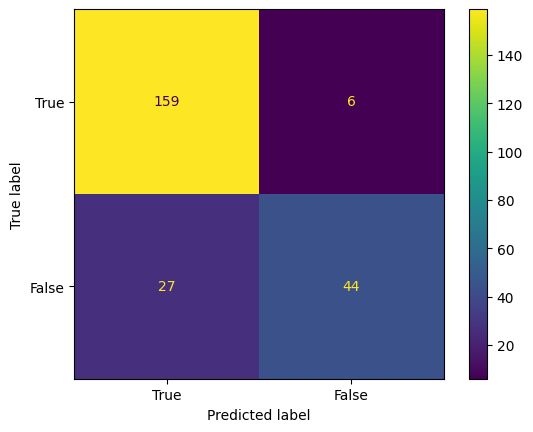

In [28]:
186+50
false_negative = 6
false_positive = 27
true_positive = 159
true_negative = 44
186+50

import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

actual = [159, 44]
predicted = [27, 6]

# confusion_matrix = metrics.confusion_matrix(actual, predicted)
confusion_matrix = np.array([[159, 6],[27, 44]])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [True, False])

cm_display.plot()
plt.show()


In [22]:
type(confusion_matrix)

numpy.ndarray

In [24]:
confusion_matrix.shape

(4, 4)

In [13]:
chat3output="If the object starts at position (3,2) and moves 2 steps to the right, it will end up at position (3,4). Then, if it moves 3 steps down, it will end up at position (5,4). Finally, if it moves 1 step to the left, it will end up at position (5,3). Therefore, the final position is (5,3). "
xxx = chat3output[-7:]
xxx = xxx[xxx.find("("):xxx.find(")")+1].replace(" ", "")
xxx

'(5,3)'

In [2]:
len(message_history)

13

In [82]:
current_position
print(str(current_position).strip(' '))

(0, 0)


In [3]:
# import os
# import time

# import openai

# # load and set our key
# openai.api_key = open("key.txt", "r").read().strip("\n")

# message_history = []
# all_messages = []
# function_messages = []
# grid_size = (5,5)
# current_position = (0,0)
# def up(pos,z):
#     temp = pos[0]-z
#     if temp<1:
#         temp = 1
#     return (temp,pos[1])

# def down(pos,z):
#     temp = pos[0]+z
#     if temp>grid_size[0]:
#         temp = grid_size[0]
#     return (temp,pos[1])

# def right(pos,z):
#     temp = pos[1]+z
#     if temp>grid_size[1]:
#         temp = grid_size[1]
#     return (pos[0],temp)

# def left(pos,z):
#     temp = pos[1]-z
#     if temp<1:
#         temp = 1
#     return (pos[0],temp)

# def chat():
#     completion = openai.ChatCompletion.create(
#         model="gpt-4", messages=message_history)
#     reply_content = completion.choices[0].message.content
#     message_history.append(
#         {"role": "assistant", "content": f"{reply_content } \n\n"})
# #     all_messages.append({"role": "assistant", "content": f"{reply_content } \n\n"})
#     return reply_content


# def chat_function():
#     function_messages = []
#     function_messages.append({"role": "user", "content": f" Could you please turn the moves to funtion call format as this helps me a lot to understand and solve the problem much better. From any position (x,y) the options for function calls are up((x,y),z), down((x,y),z), left((x,y),z) or right((x,y),z) where z shows how many step the object is move to a direction. Please only tell me the start posiosion followed by the moves using the functions seperated by a semicolon. Example: Starting from position (3,2) move the object one time right and them move the object two times down. The function call must be in the following format: (3,2);right((x,y),1);down((x,y),2) \n\n"})
#     function_messages.append(
#         {"role": "user", "content": f"Please turn the moves in this message to function calls:{message_history[-1:] } \n\n"})
# #     print("Function message is: ", function_messages)
     
#     completion = openai.ChatCompletion.create(
#         model="gpt-4", messages=function_messages)
#     reply_content = completion.choices[0].message.content
#     print("Reply to function message is: ", reply_content)
#     # message_history.append({"role": "assistant", "content": f"{reply_content } \n\n"})
#     function_messages.append(
#         {"role": "assistant", "content": f"{reply_content } \n\n"})
#     splited_message = reply_content.split(";")
#     splited_message
#     for item in splited_message:
#         if item[0:1]== "(":
#             current_posision = (int(item[1:2]),int(item[3:4]))
#             print(current_posision)
#             print(type(current_posision))
#         if item[0:1]== "l":
#             print()
#             current_posision = left(current_posision,int(item[5:6]))
#         if item[0:1]== "r":
#             tempnum = int(item[6:7])
#             print(type(tempnum))
#             current_posision = right(current_posision,tempnum)
#         if item[0:1]== "u":
#             current_posision = up(current_posision,int(item[3:4]))
#         if item[0:1]== "d":
#             current_posision = down(current_posision,int(item[5:6]))
#     print("The current position is: ", current_posision)
#     return reply_content


# def chat_gpt3():
#     completion = openai.ChatCompletion.create(
#         model="gpt-3.5-turbo", messages=message_history[2:])
#     reply_content = completion.choices[0].message.content
#     message_history.append(
#         {"role": "assistant", "content": f"{reply_content } \n\n"})
# #     all_messages.append({"role": "assistant", "content": f"{reply_content } \n\n"})
#     return reply_content


# def swaproles():
#     for message in message_history:
#         if message['role'] == 'user':
#             message['role'] = 'assistant'
#         elif message['role'] == 'assistant':
#             message['role'] = 'user'


# # Set roudns to the number of rounds you want to play!
# #
# for rounds in range(1):
#     message_history = []
#     # put your system prompt below
#     systemContent = f"You're asking questions to a human student to know their level of common sense capabilities, e.g., in spatial reasoning. There is a {grid_size[0]} by {grid_size[1]} grid. There is an object in an initial square. Ask the student the imagine moving it a number of times up,right,left or down and then ask the student to tell you the final position of the object in the grid. When asking the first question explain to the student that the osition of the object can be expressed with a touple in the format of (row,column). Continue asking until they make a mistake.User should responde in the format of FINAL POSITION=(ROW, COLUMN). If the answer is correct, you should say CORRECT and keep on refining or adding complexity to the question to find a failure of common sense understanding. When that happens you have to say INCORRECT, and the test is over. \n\n"
#     message_history.append({"role": 'system', "content": systemContent})
# #     all_messages.append({"role": 'system', "content": systemContent})
#     message_history.append(
#         {"role": 'user', "content": f"Hello, I am a human student. I am ready to answer your questions.\n\n"})
# #     all_messages.append({"role": 'user', "content": f"Hello, I am a human student. I am ready to answer your questions.\n\n"})
#     print(message_history[0]['content'])
#     print(message_history[1]['content'])
#     try:
#         while True:

#             temp = chat()
#             if temp[0:9] == "INCORRECT":
#                 print('found incorrect')
#                 print(temp)
#                 swaproles()
#                 break
#             print(temp)
#             functionByGPT = chat_function()
#             print("functionByGpt is: ", functionByGPT)
#             swaproles()
#             time.sleep(3)
#             print(chat_gpt3())
#             swaproles()
#             time.sleep(3)

#     except Exception as e:
#         file1 = open('self_chat_5by5.txt', 'a', encoding='utf-8')
#         file1.writelines('****************************************')
#         file1.writelines(str(e))
#         file1.writelines('****************************************')
#         file1.close()

#     for item in message_history:
#         print(item['content'])
#         file1 = open('self_chat_5by5.txt', 'a', encoding='utf-8')
#         file1.writelines(str(item['content']))
#         file1.close()

#     print(message_history)
#     print(function_messages)


You're asking questions to a human student to know their level of common sense capabilities, e.g., in spatial reasoning. There isa 5 by 5 grid. There is an object in an initial square. Ask the student the imagine moving it a number of times up,right,left or down and then ask the student to tell you the final position of the object in the grid. When asking the first question explain to the student that the osition of the object can be expressed with a touple in the format of (row,column). Continue asking until they make a mistake. If the answer is correct, you should say CORRECT and keep on refining or adding complexity to the question to find a failure of common sense understanding. When that happens you have to say INCORRECT, and the test is over. 


Hello, I am a human student. I am ready to answer your questions.


Great! Here is our first situation. We have a grid that is 5 by 5 and there is an object on it. Each square can be addressed by a pair of numbers in the format of (row, c

CORRECT. Now, from position (3, 4) if we move the object one square down and two squares left, what would be the final position of the object in the grid? 


Function message is:  [{'role': 'user', 'content': ' Could you please turn the moves to funtion call format as this helps me a lot to understand and solve the problem much better. From any position (x,y) the options for function calls are up((x,y),z), down((x,y),z), left((x,y),z) or right((x,y),z) where z shows how many step the object is move to a direction. Please only tell me the start posiosion followed by the moves using the functions seperated by a semicolon. Example: Starting from position (3,2) move the object one time right and them move the object two times down. The function call must be in the following format: (3,2);right((x,y),1);down((x,y),2) \n\n'}, {'role': 'user', 'content': "Please turn the moves in this message to function calls:[{'role': 'assistant', 'content': 'CORRECT. Now, from position (3, 4) if we move th

Great. Let's begin. There is a 5 by 5 grid, you have an object placed in the square at position (3,3). If you move that object 1 square up, what will be its new position?
Function message is:  [{'role': 'user', 'content': ' Could you please turn the moves to funtion call format as this helps me a lot to understand and solve the problem much better. From any position (x,y) the options for function calls are up((x,y),z), down((x,y),z), left((x,y),z) or right((x,y),z) where z shows how many step the object is move to a direction. Please only tell me the start posiosion followed by the moves using the functions seperated by a semicolon. Example: Starting from position (3,2) move the object one time right and them move the object two times down. The function call must be in the following format: (3,2);right((x,y),1);down((x,y),2) \n\n'}, {'role': 'user', 'content': 'Please turn the moves in this message to function calls:[{\'role\': \'assistant\', \'content\': "Great. Let\'s begin. There is

In [4]:
function_messages

[]

In [27]:
current_posision = (3,3)
grid_size = (5,5)
def up(pos,z):
    temp = pos[0]-z
    if temp<1:
        temp = 1
    return (temp,pos[1])
up(current_posision,2)

def down(pos,z):
    temp = pos[0]+z
    if temp>grid_size[0]:
        temp = grid_size[0]
    return (temp,pos[1])
down(current_posision,5)

def right(pos,z):
    temp = pos[1]+z
    if temp>grid_size[1]:
        temp = grid_size[1]
    return (pos[0],temp)
right(current_posision,1)

def left(pos,z):
    temp = pos[1]-z
    if temp<1:
        temp = 1
    return (pos[0],temp)
left(current_posision,2)

(3, 1)

In [50]:
current_posision = (0,0)
func_mess = "(2,3);right(2);up(3)"
splited_message = func_mess.split(";")
splited_message
for item in splited_message:
    if item[0:1]== "(":
        current_posision = (int(item[1:2]),int(item[3:4]))
        print(current_posision)
        print(type(current_posision))
    if item[0:1]== "l":
        print()
        current_posision = left(current_posision,int(item[5:6]))
    if item[0:1]== "r":
        tempnum = int(item[6:7])
        print(type(tempnum))
        current_posision = right(current_posision,tempnum)
    if item[0:1]== "u":
        current_posision = up(current_posision,int(item[3:4]))
    if item[0:1]== "d":
        current_posision = down(current_posision,int(item[5:6]))
current_posision

(2, 3)
<class 'tuple'>
<class 'int'>


(1, 5)

In [47]:
tuple("23")

('2', '3')